In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-24 18:51:23.258005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 18:51:23.275325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 18:51:23.280653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Evaluate bulk properties

In [3]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    #'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : [  'uphp_rotated',
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    'use_coeff_channels': False,
                    'single_layer_mask': True,

                    'all_time_range': slice(3600-513, 3600),
                    #'train_time_range': slice(0, 2048),
                    #'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-513, None),
                    #'num_train_batches': 128, 
                    #'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],

                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/main_models/window_all/shape_48_48_2/'
                    
            }

In [4]:
experiment_configs = {'1point':{'window_size':1, 'num_inputs':6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'1point'},
                      '3point':{'window_size':3, 'num_inputs':3*3*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'3point'},
                      '5point':{'window_size':5, 'num_inputs':5*5*6, 'exp_ckpt_save_dir': common_config['ckpt_save_dir']+'5point'}    
                        }

In [5]:
sub_keys = ['1point','3point']

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
for key in sub_keys:#experiment_configs.keys():

    print('Starting to load in DT for: ' + key)
    
    experiment_configs[key]['DT'] = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                         filter_scales=common_config['filter_scales'], 
                         window_size = experiment_configs[key]['window_size'], 
                         time_sel = common_config['all_time_range'],
                         single_layer_mask_flag=common_config['single_layer_mask']
                         )

    print('Opening up eval sys: ' + key)
    experiment_configs[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=experiment_configs[key]['DT'],
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs=experiment_configs[key]['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=experiment_configs[key]['exp_ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

    print('Reading model and predicting: ' + key)
    
    experiment_configs[key]['eval_sys'].read_ann_regression_model()
    experiment_configs[key]['eval_sys'].read_eval_data()
    experiment_configs[key]['eval_sys'].predict()
    experiment_configs[key]['eval_sys'].dimensionalize()

Starting to load in DT for: 1point
Opening up eval sys: 1point
Reading model and predicting: 1point
Starting to load in DT for: 3point
Opening up eval sys: 3point
Reading model and predicting: 3point


In [ ]:
for key in ['5point']:#experiment_configs.keys():

    print('Starting to load in DT for: ' + key)
    
    experiment_configs[key]['DT'] = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                         filter_scales=common_config['filter_scales'], 
                         window_size = experiment_configs[key]['window_size'], 
                         time_sel = common_config['all_time_range'],
                         single_layer_mask_flag=common_config['single_layer_mask']
                         )

    print('Opening up eval sys: ' + key)
    experiment_configs[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=experiment_configs[key]['DT'],
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs=experiment_configs[key]['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=experiment_configs[key]['exp_ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

    print('Reading model and predicting: ' + key)
    
    experiment_configs[key]['eval_sys'].read_ann_regression_model()
    experiment_configs[key]['eval_sys'].read_eval_data()
    experiment_configs[key]['eval_sys'].predict()
    experiment_configs[key]['eval_sys'].dimensionalize()

In [7]:
# Make predictions using GM and VGM models 

for key in ['1point']:#experiment_configs.keys(): 
    experiment_configs[key]['eval_sys'].add_gradient_model_variables()
    experiment_configs[key]['eval_sys'].add_gent_mcwilliams_variables()

In [8]:
%%time
for key in sub_keys: 
    experiment_configs[key]['eval_sys'].coarsen_time_ML_data()
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])
    print('here')
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='layerwise', dims=['Time','xh','yh'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='layerwise', dims=['Time','xh','yh'], use_default_subregions=True)

here
here
CPU times: user 31min 44s, sys: 7min 22s, total: 39min 7s
Wall time: 12min 55s


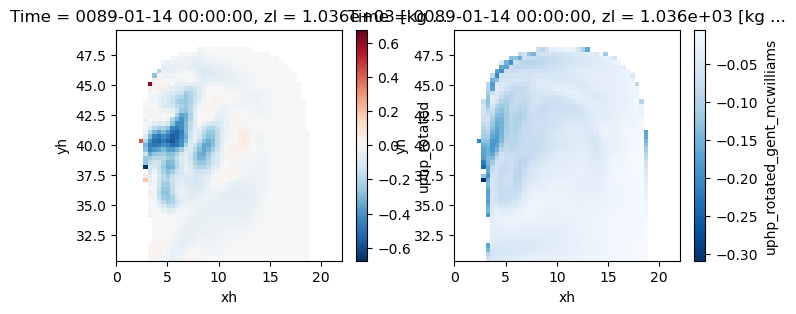

In [18]:
plt.figure(figsize=(8,3))
zl = 1
scale = '200'
plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][scale]['256'].uphp_rotated.isel(Time=0,zl=1).plot()

plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][scale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0,zl=1).plot(cmap='Blues_r')

In [14]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['200']['256'].uphp_rotated_R2_layerwise

<xarray.DataArray 'uphp_rotated_R2_layerwise' (zl: 2)> Size: 16B
array([0.37287088, 0.23469784])
Coordinates:
  * zl       (zl) float64 16B 1.035e+03 1.036e+03

In [15]:
experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset['DG']['200']['256'].uphp_rotated_R2_layerwise

<xarray.DataArray 'uphp_rotated_R2_layerwise' (zl: 2)> Size: 16B
array([0.81663785, 0.83696225])
Coordinates:
  * zl       (zl) float64 16B 1.035e+03 1.036e+03

In [21]:
%%time
for key in ['1point']: 
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='time', dims=['Time'])
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='time', dims=['Time'])

    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    #experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)

    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='uphp_rotated', descriptor='layerwise', dims=['Time','xh','yh'], use_default_subregions=True)
    experiment_configs[key]['eval_sys'].calc_time_hor_space_metrics_trad_models(var='vphp_rotated', descriptor='layerwise', dims=['Time','xh','yh'], use_default_subregions=True)

CPU times: user 18min 27s, sys: 1min 44s, total: 20min 12s
Wall time: 7min 39s


In [22]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['200']['256'].uphp_rotated_R2_gent_mcwilliams_layerwise

<xarray.DataArray 'uphp_rotated_R2_gent_mcwilliams_layerwise' (zl: 2)> Size: 16B
array([-0.3834189 ,  0.18589149])
Coordinates:
  * zl       (zl) float64 16B 1.035e+03 1.036e+03

In [23]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['100']['256'].uphp_rotated_R2_gent_mcwilliams_layerwise

<xarray.DataArray 'uphp_rotated_R2_gent_mcwilliams_layerwise' (zl: 2)> Size: 16B
array([0.17201061, 0.4551166 ])
Coordinates:
  * zl       (zl) float64 16B 1.035e+03 1.036e+03

In [51]:
experiment_configs['3point']['eval_sys'].coarsen_times

['16', '64', '128', '256']

In [50]:

data_keys = list(common_config['simulation_names'])
model_keys = ['1point', '3point', 'grad_model', 'gent_mcwilliams']
filter_scales = common_config['filter_scales']
coarsen_time_scales = experiment_configs['3point']['eval_sys'].coarsen_times.copy()
coarsen_time_scales.insert(0, '0')


R2_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys)), np.nan)
corr_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys)), np.nan)

for i, data_key in enumerate(data_keys):
    for l, model_key in enumerate(model_keys):
        for j, scale_key in enumerate(filter_scales):
            for k, coarsen_key in enumerate(coarsen_time_scales):
        
                if coarsen_key == '0': 
                    if model_key == 'grad_model':
                        R2_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_grad_model_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_grad_model_all.values )
                    elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                        R2_data[i, j, k, l] = (experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_gent_mcwilliams_all.values)
            
                        corr_data[i, j, k, l] = (experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_gent_mcwilliams_all.values)
                    else:
                        R2_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_R2_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_R2_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].uphp_rotated_corr_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key].vphp_rotated_corr_all.values )

                else: 
                    if model_key == 'grad_model':
                        R2_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_R2_grad_model_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_grad_model_all.values +
                                        experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_corr_grad_model_all.values )
                    elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                        R2_data[i, j, k, l] = (experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_gent_mcwilliams_all.values)
            
                        corr_data[i, j, k, l] = (experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_gent_mcwilliams_all.values)
                    else:
                        R2_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_R2_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_R2_all.values )
            
                        corr_data[i, j, k, l] = 0.5*(experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].uphp_rotated_corr_all.values +
                                        experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key].vphp_rotated_corr_all.values )

bulk_skill_metrics = xr.Dataset()

bulk_skill_metrics['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys})

bulk_skill_metrics['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys})

#bulk_skill_metrics.to_netcdf('bulk_skill_metrics.nc')

AttributeError: 'DataTree' object has no attribute 'uphp_rotated_R2_all'

In [45]:
experiment_configs[key]['eval_sys'].coarsen_times 

In [58]:
data_keys = list(common_config['simulation_names'])
model_keys = ['1point', '3point', 'grad_model', 'gent_mcwilliams']
filter_scales = common_config['filter_scales']
coarsen_time_scales = experiment_configs['3point']['eval_sys'].coarsen_times.copy()
coarsen_time_scales.insert(0, '0')
direction = ['uphp','vphp']
levels = [0,1]


R2_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys), len(levels), len(direction)), np.nan)
corr_data = np.full((len(data_keys), len(filter_scales), len(coarsen_time_scales), len(model_keys), len(levels), len(direction)), np.nan)

for i, data_key in enumerate(data_keys):
    for l, model_key in enumerate(model_keys):
        for j, scale_key in enumerate(filter_scales):
            for k, coarsen_key in enumerate(coarsen_time_scales):
                for m, lev_key in enumerate(levels):
                    for n, dir_key in enumerate(direction):
                        
                    
                        if coarsen_key == '0': 
                            if model_key == 'grad_model':
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_R2_grad_model_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_corr_grad_model_layerwise'].isel(zl=lev_key).values 
                            elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_R2_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_corr_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                            else:
                                R2_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_R2_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][dir_key+'_rotated_corr_layerwise'].isel(zl=lev_key).values 
        
                        else: 
                            if model_key == 'grad_model':
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_R2_grad_model_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_corr_grad_model_layerwise'].isel(zl=lev_key).values 
                            elif model_key == 'gent_mcwilliams': # we only use downgradient prediction for this case.
                                R2_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_R2_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_corr_gent_mcwilliams_layerwise'].isel(zl=lev_key).values 
                            else:
                                R2_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_R2_layerwise'].isel(zl=lev_key).values 
                                corr_data[i, j, k, l, m, n ] = experiment_configs[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale_key][coarsen_key][dir_key+'_rotated_corr_layerwise'].isel(zl=lev_key).values 



bulk_skill_metrics = xr.Dataset()

bulk_skill_metrics['R2'] = xr.DataArray(R2_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys,
                                                         'layer': levels,
                                                         'direction': direction})

bulk_skill_metrics['corr'] = xr.DataArray(corr_data, coords={'data_set':data_keys,
                                                          'filter_scales': list(map(int, filter_scales)),
                                                         'coarsen_time': list(map(int, coarsen_time_scales)), 
                                                          'model': model_keys, 
                                                            'layer': levels, 
                                                         'direction': direction})
bulk_skill_metrics.to_netcdf('bulk_skill_metrics_layerwise_with_dir.nc')

In [60]:
bulk_skill_metrics

<xarray.Dataset> Size: 11kB
Dimensions:        (data_set: 2, filter_scales: 4, coarsen_time: 5, model: 4,
                    layer: 2, direction: 2)
Coordinates:
  * data_set       (data_set) <U3 24B 'DG' 'P2L'
  * filter_scales  (filter_scales) int64 32B 50 100 200 400
  * coarsen_time   (coarsen_time) int64 40B 0 16 64 128 256
  * model          (model) <U15 240B '1point' '3point' ... 'gent_mcwilliams'
  * layer          (layer) int64 16B 0 1
  * direction      (direction) <U4 32B 'uphp' 'vphp'
Data variables:
    R2             (data_set, filter_scales, coarsen_time, model, layer, direction) float64 5kB ...
    corr           (data_set, filter_scales, coarsen_time, model, layer, direction) float64 5kB ...

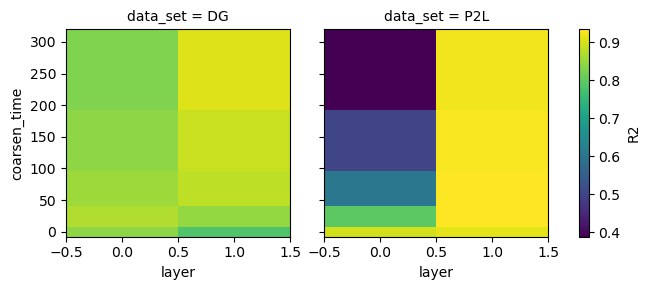

In [28]:
bulk_skill_metrics.sel(filter_scales=100, model='1point').R2.plot(col='data_set')

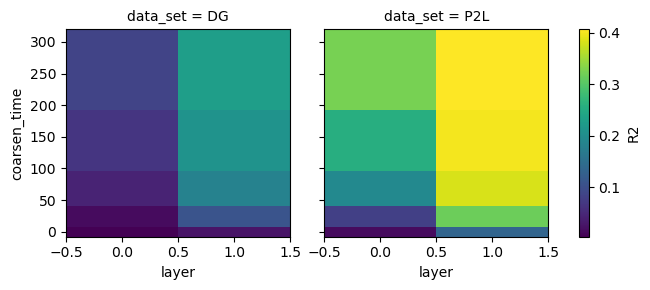

In [29]:
bulk_skill_metrics.sel(filter_scales=100, model='gent_mcwilliams').R2.plot(col='data_set')

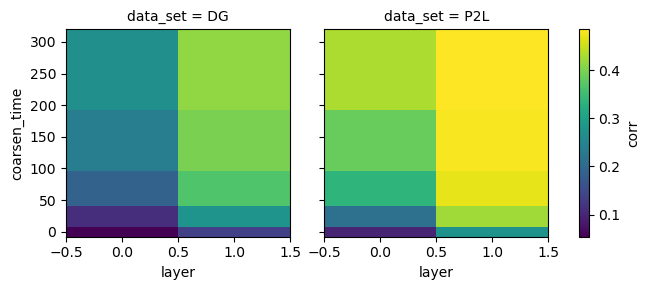

In [30]:
bulk_skill_metrics.sel(filter_scales=100, model='gent_mcwilliams').corr.plot(col='data_set')

## DG Figures

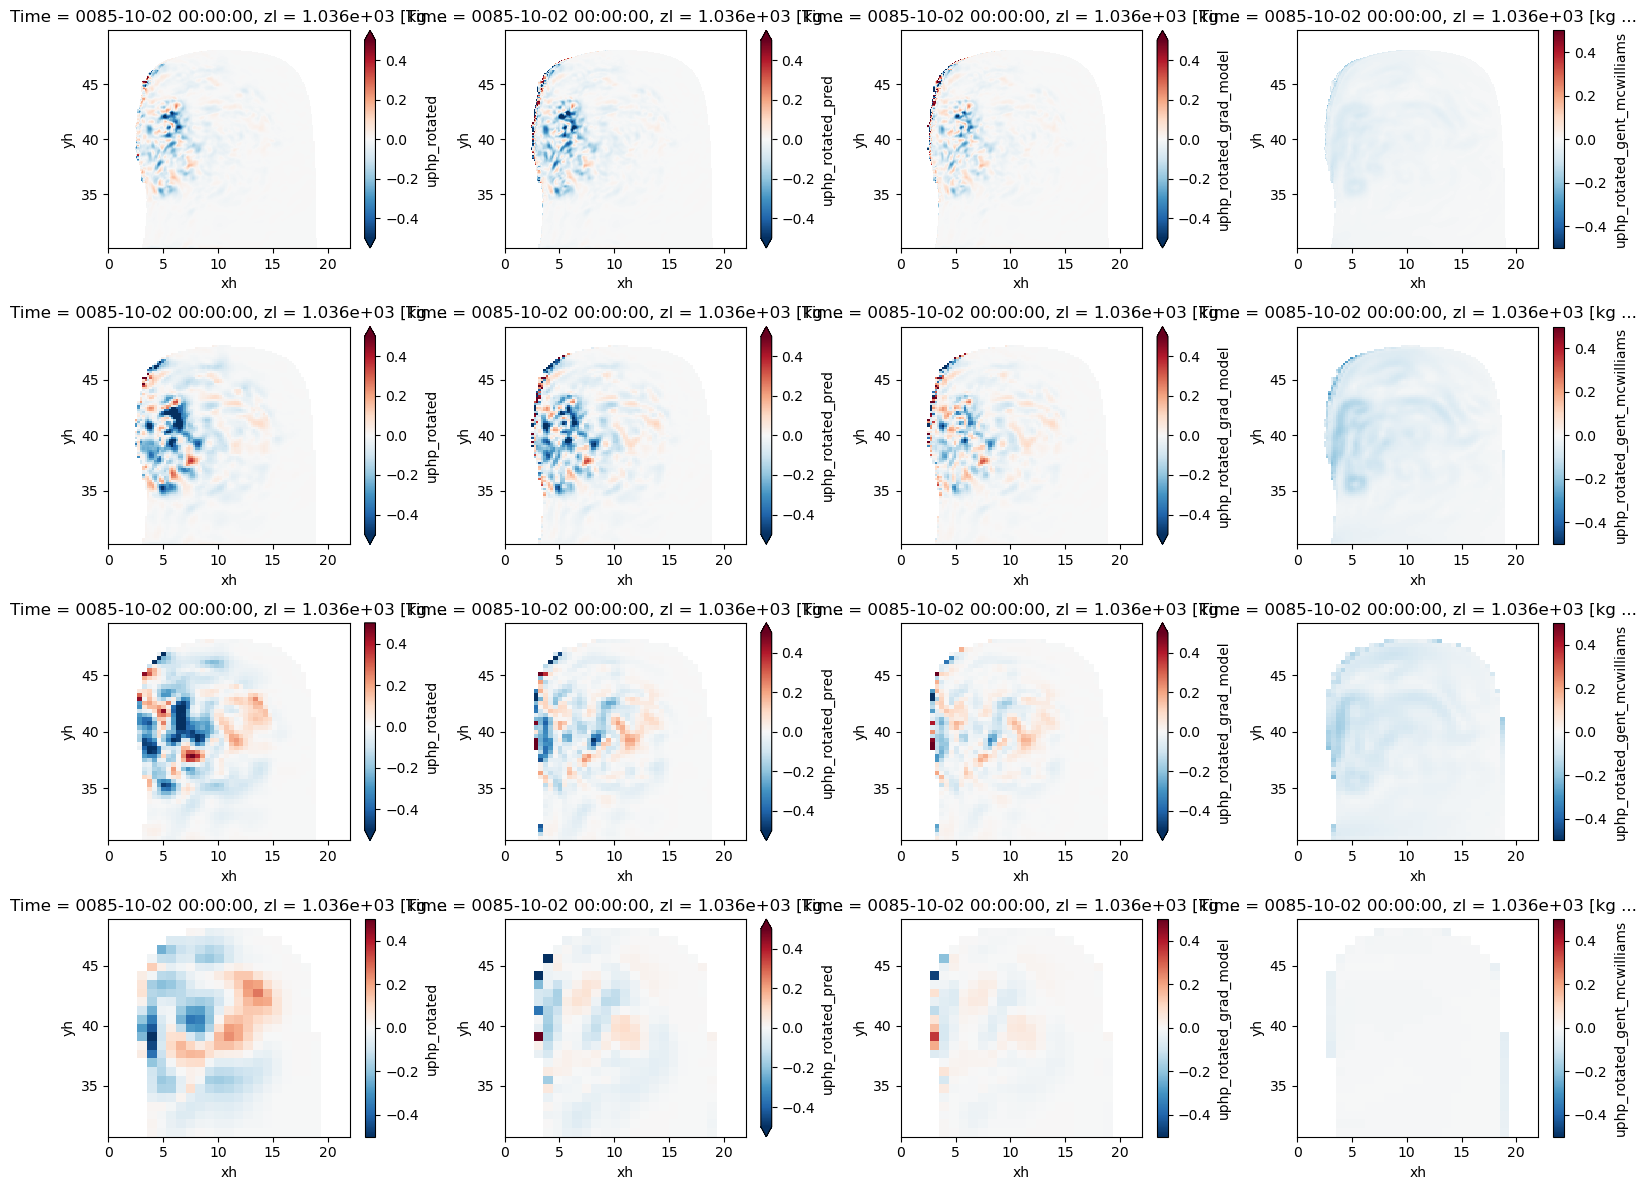

In [75]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'DG'

vmins = [-0.5, -0.5, -0.5, -.5]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

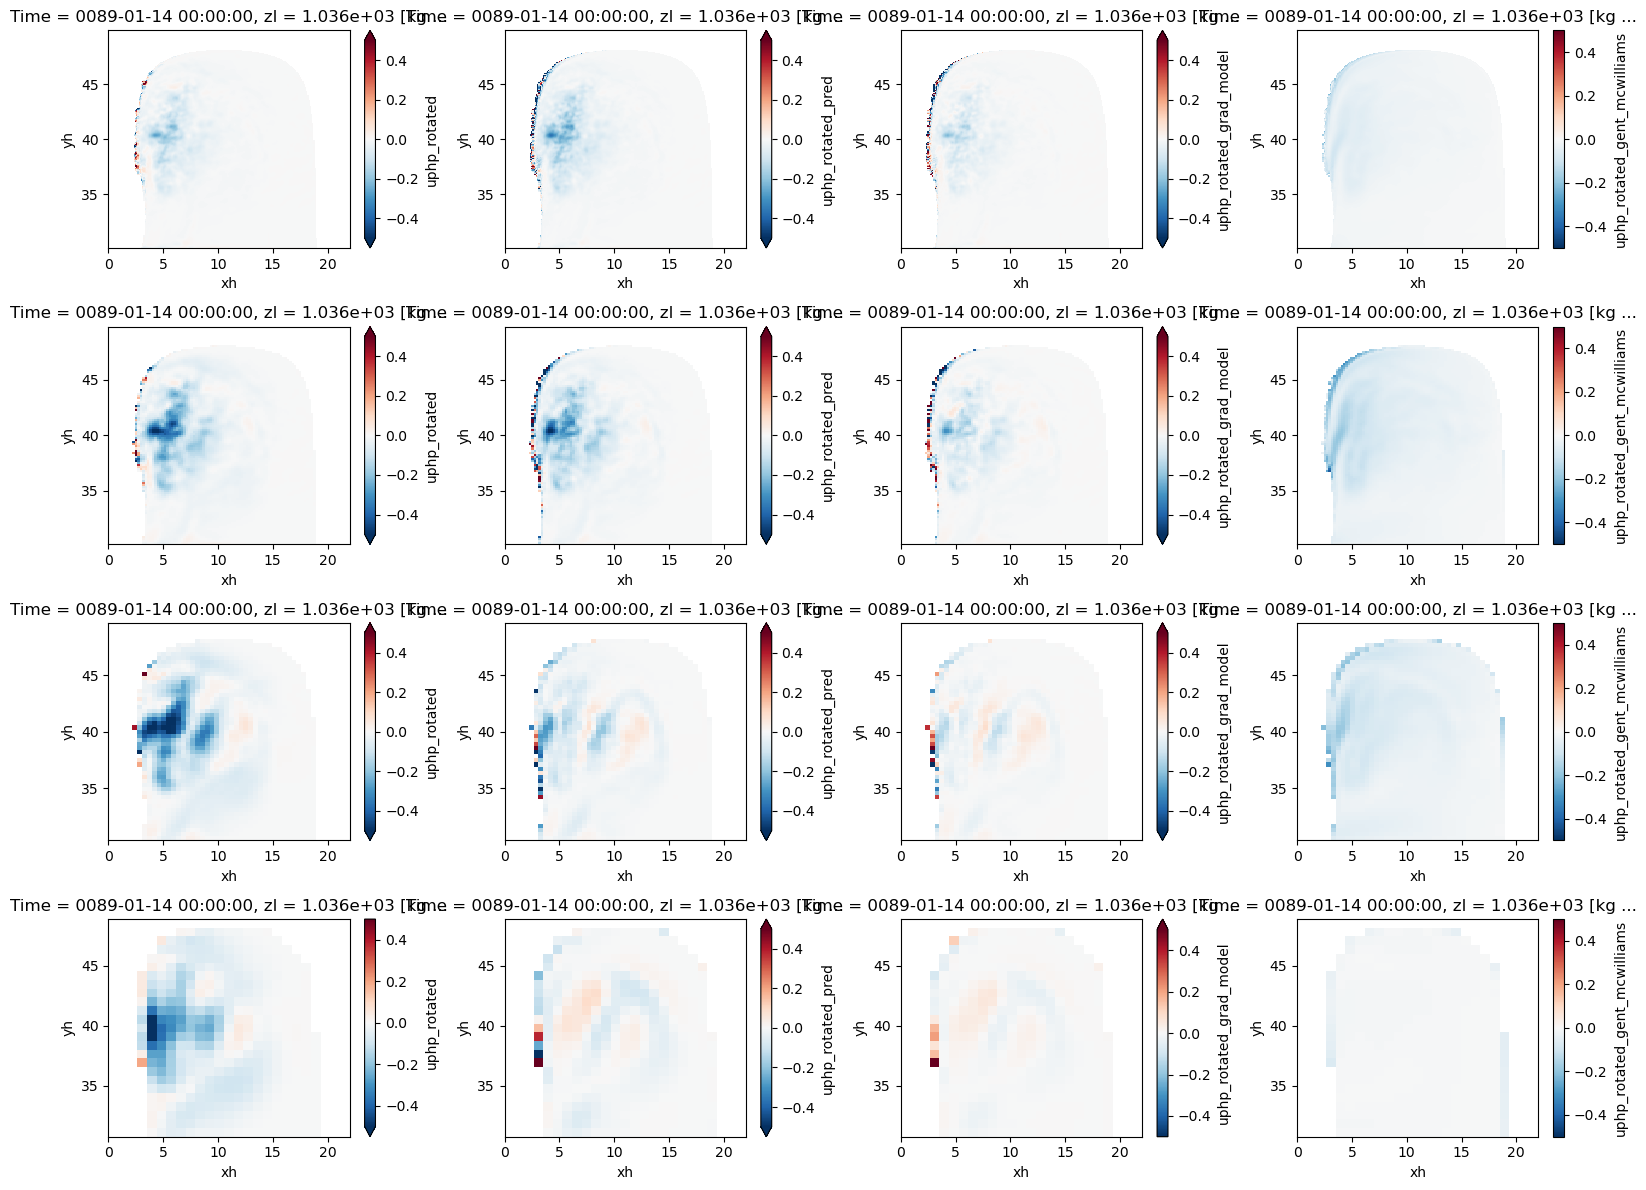

In [25]:
plt.figure(figsize=(16,12))

coarsen_scale = '256'
exp = 'DG'

vmins = [-0.5, -0.5, -0.5, -.5]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

In [ ]:
plt.figure(figsize=(16,12))

coarsen_scale = '256'
exp = 'DG'

vmins = [-0.5, -0.5, -0.5, -.5]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

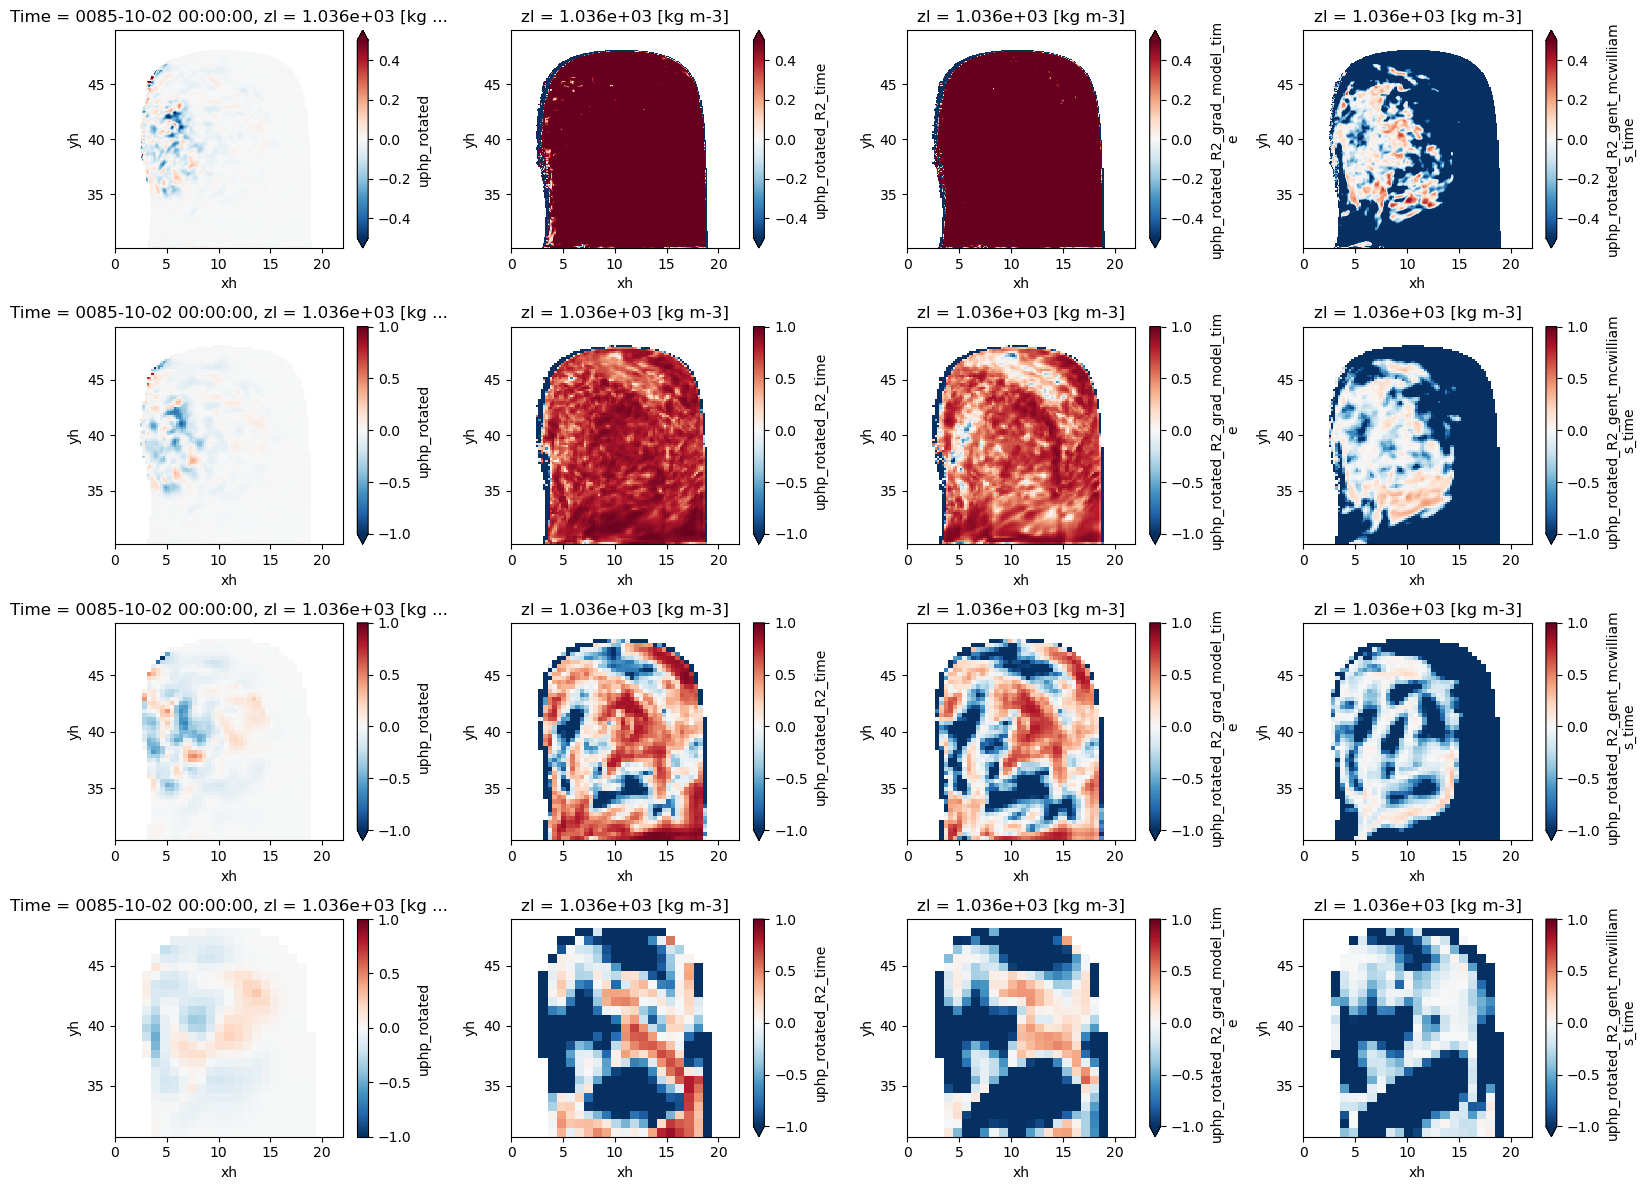

In [81]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'DG'

vmins = [-0.5, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

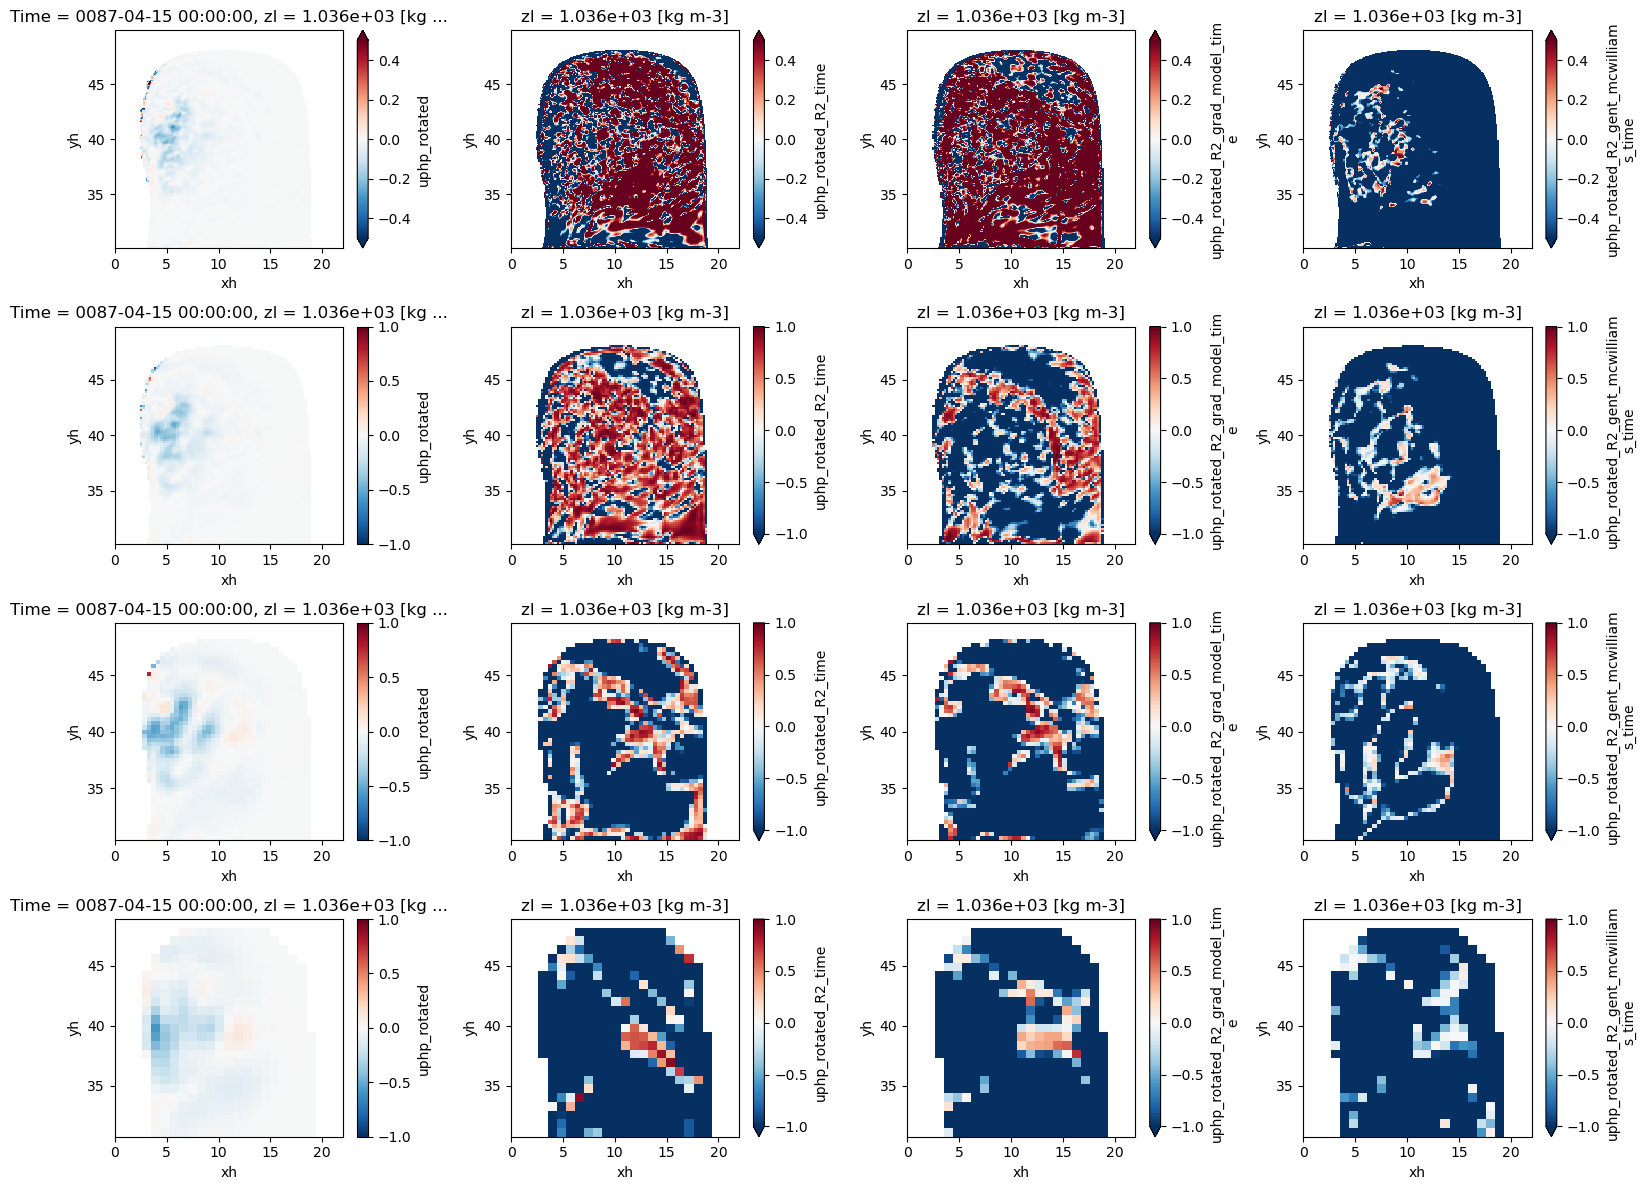

In [86]:
plt.figure(figsize=(16,12))

coarsen_scale = '128'
exp = 'DG'

vmins = [-0.5, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

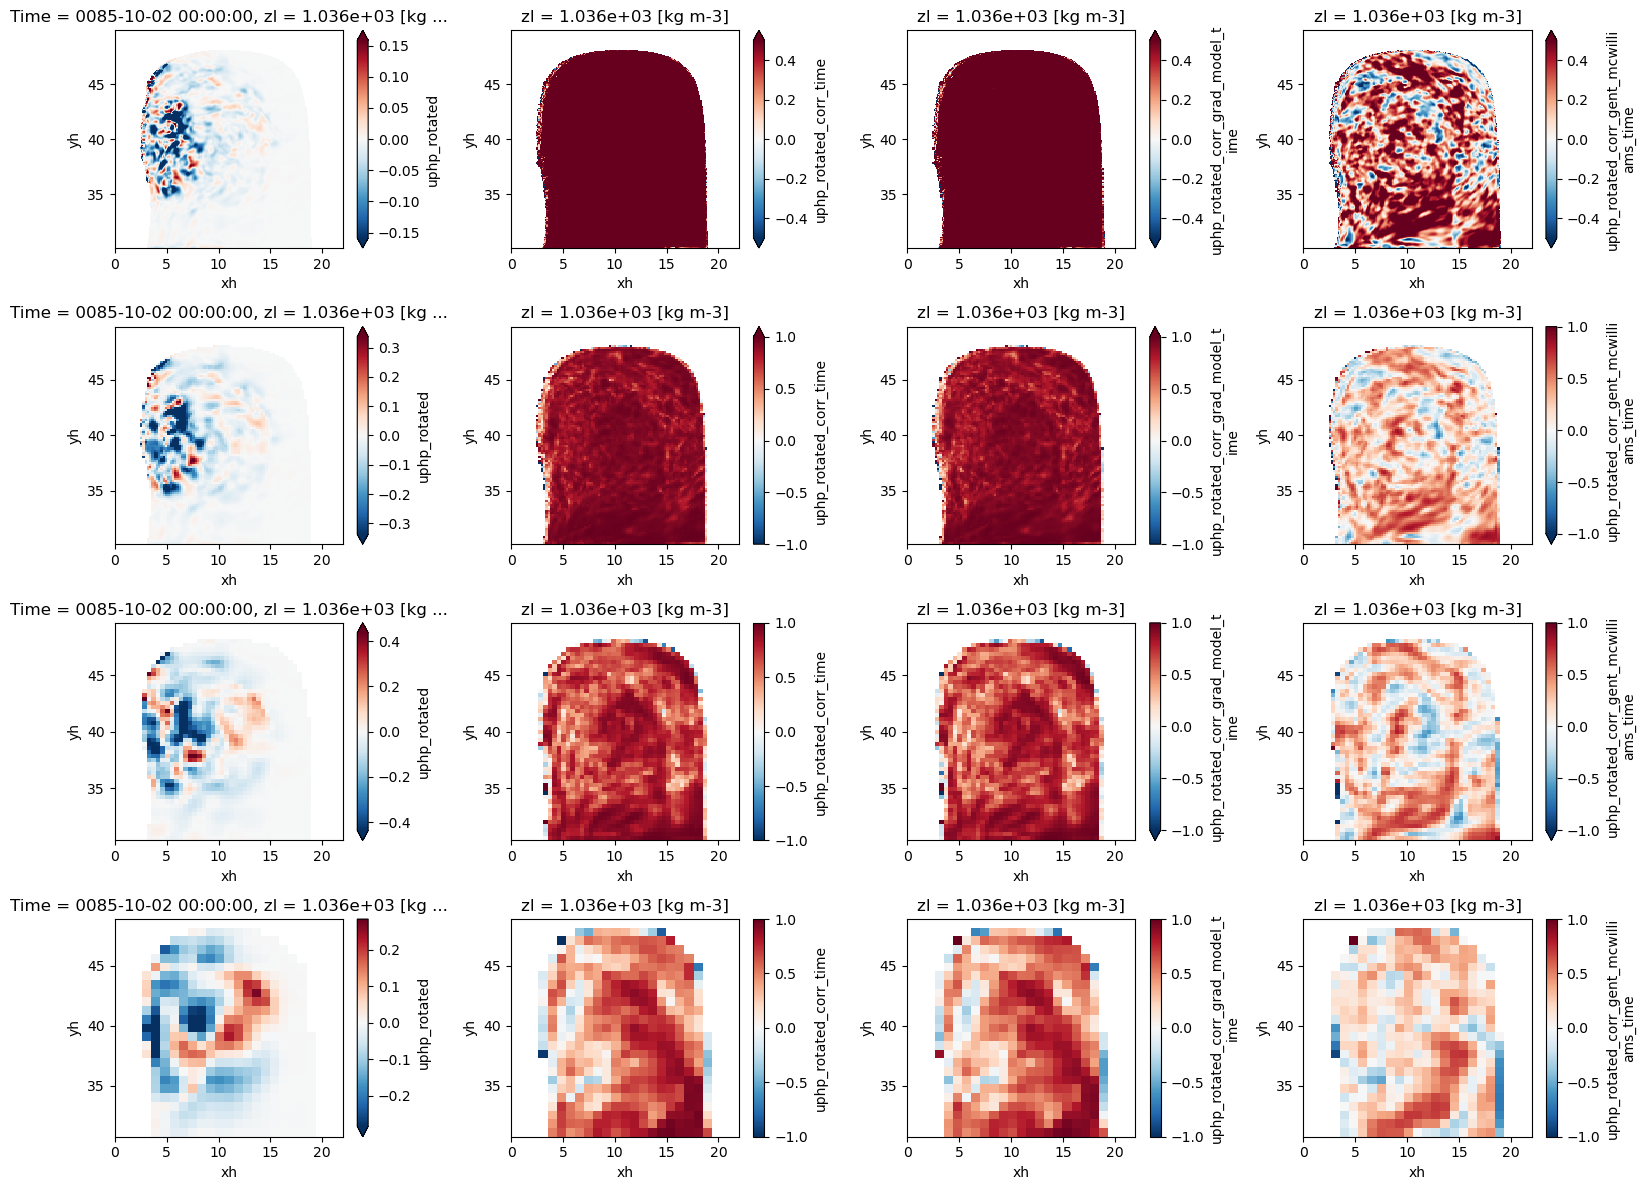

In [92]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'DG'

vmins = [-0.5, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

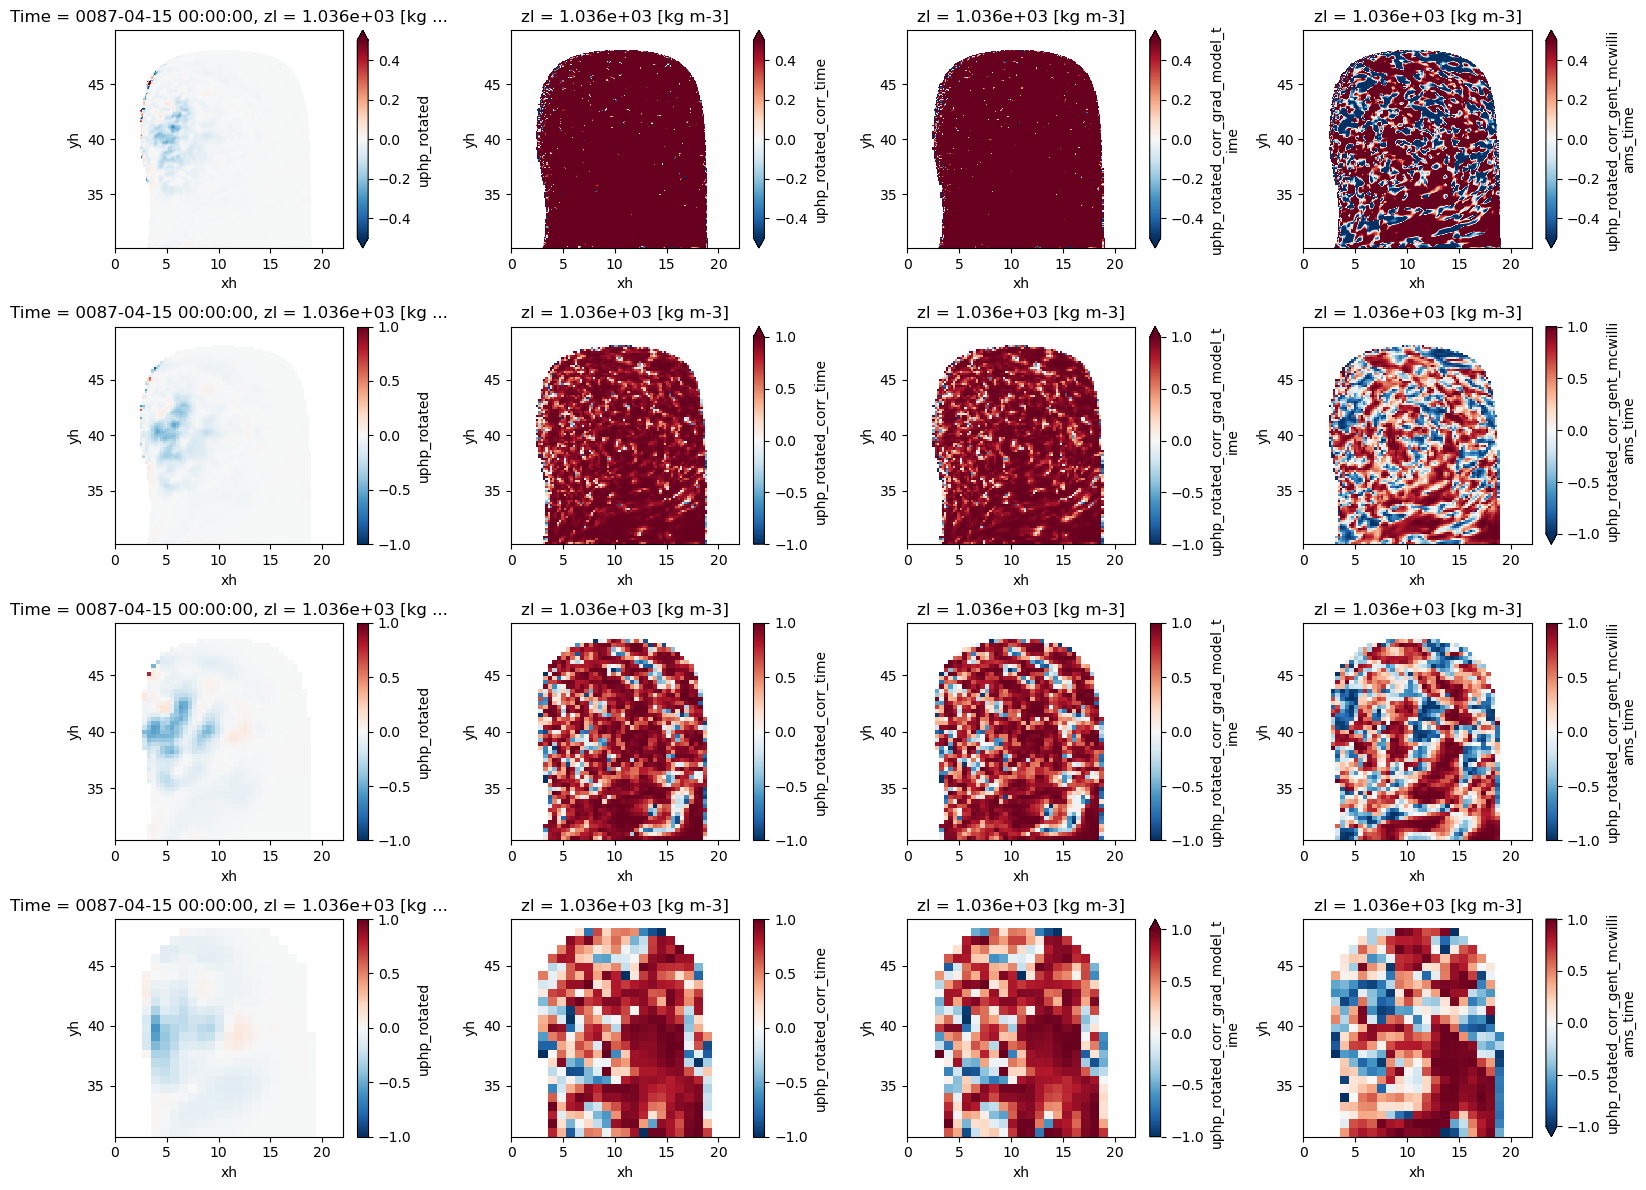

In [84]:
plt.figure(figsize=(16,12))

coarsen_scale = '128'
exp = 'DG'

vmins = [-0.5, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

# P2L

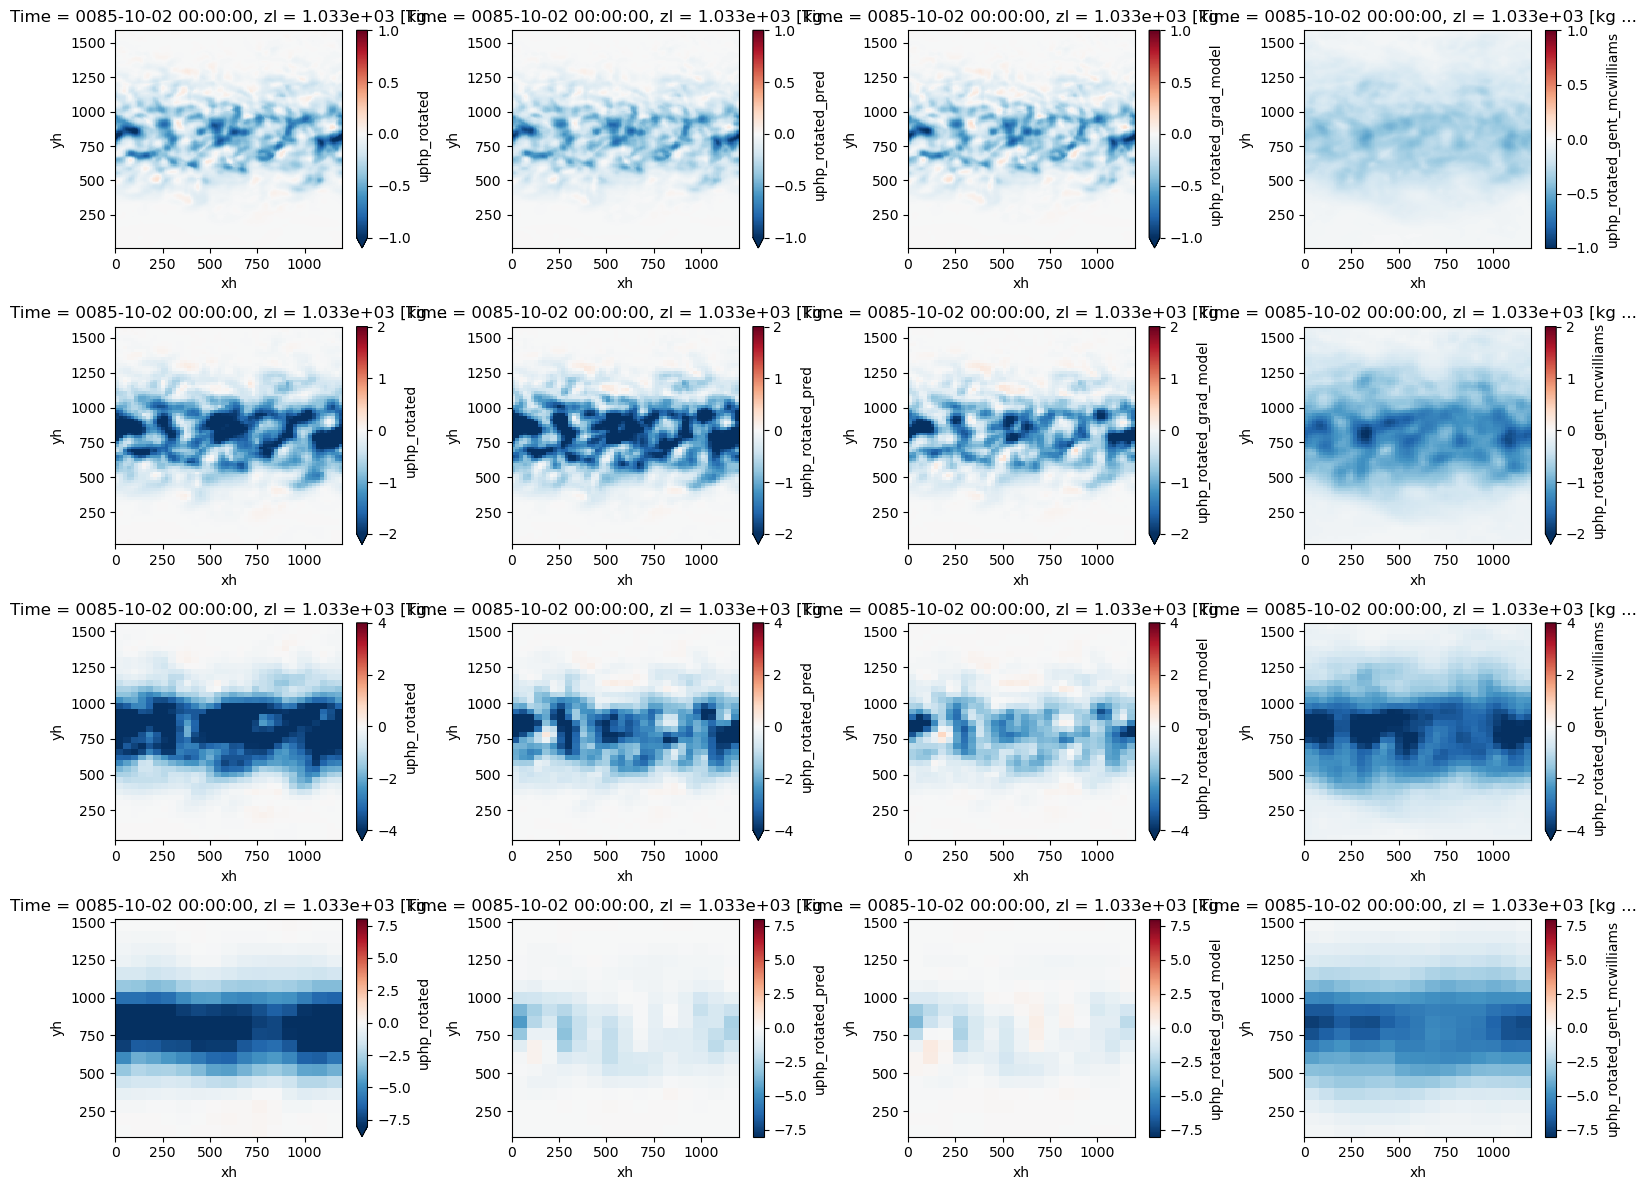

In [78]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'P2L'

vmins = [-1, -2, -4, -8]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

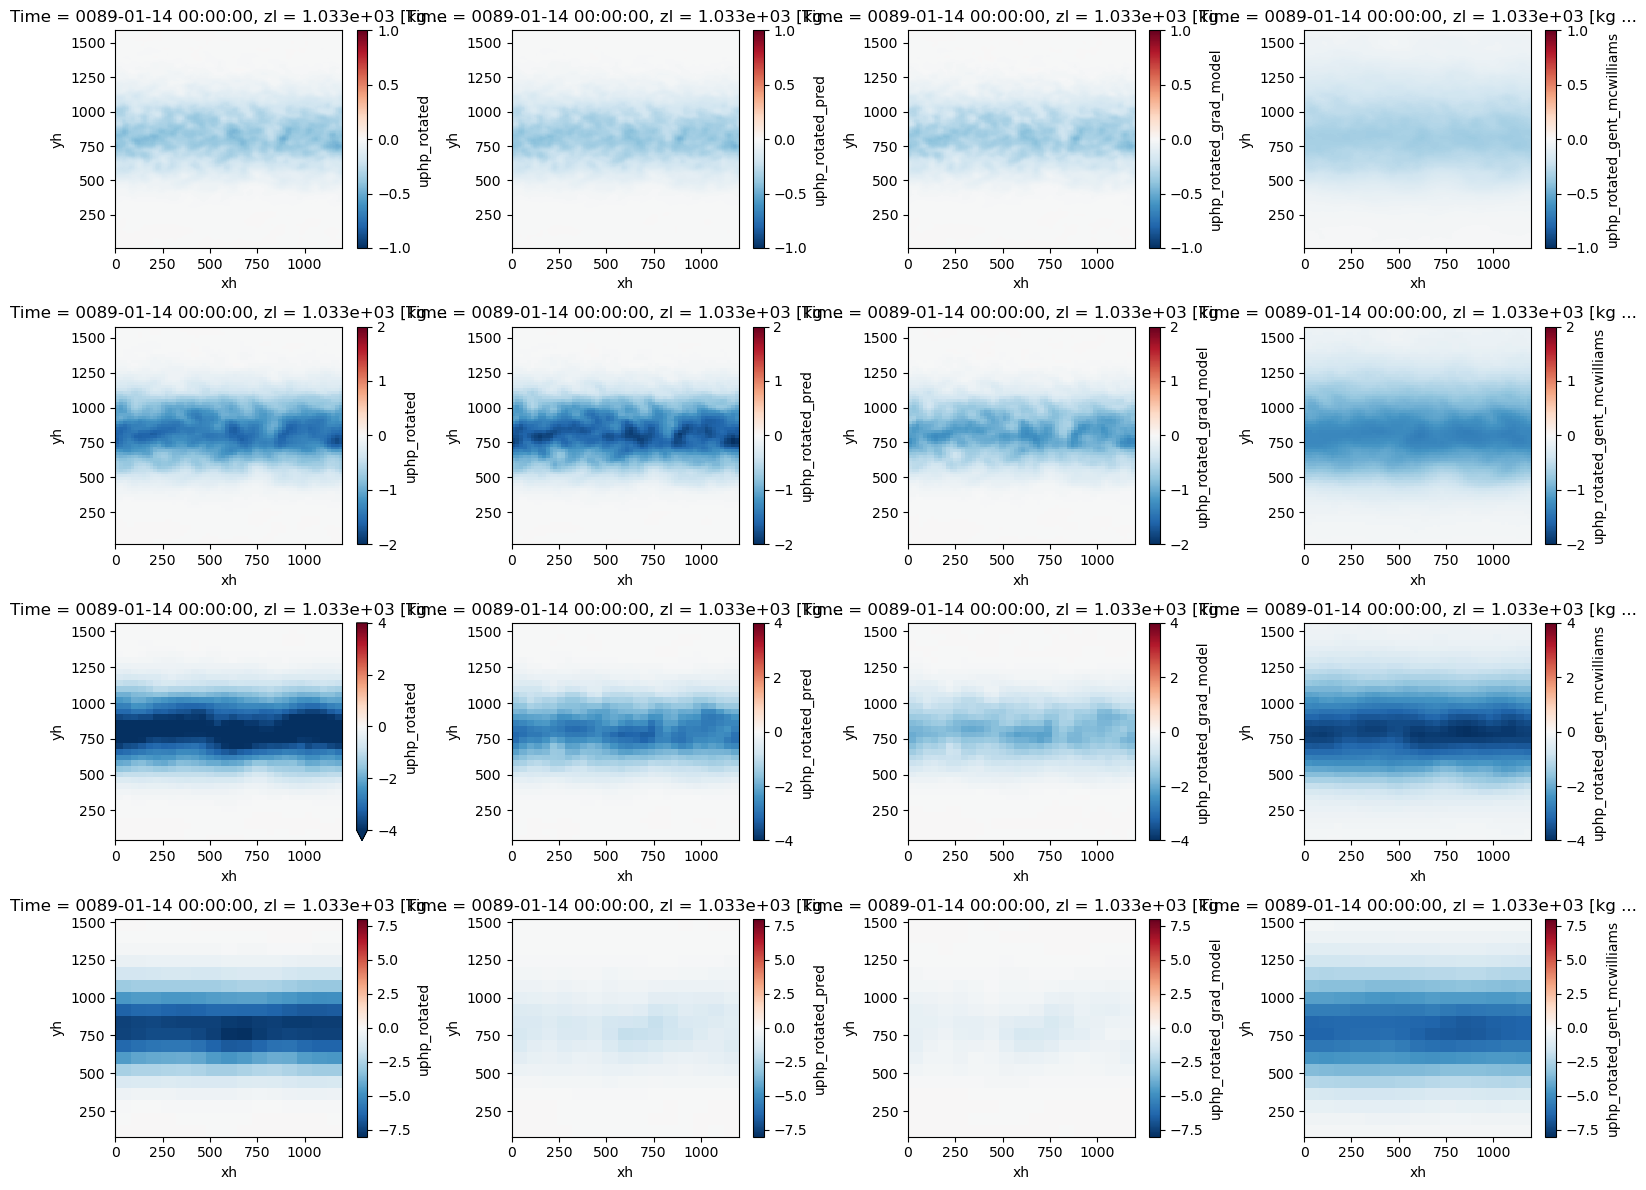

In [79]:
plt.figure(figsize=(16,12))

coarsen_scale = '256'
exp = 'P2L'

vmins = [-1, -2, -4, -8]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

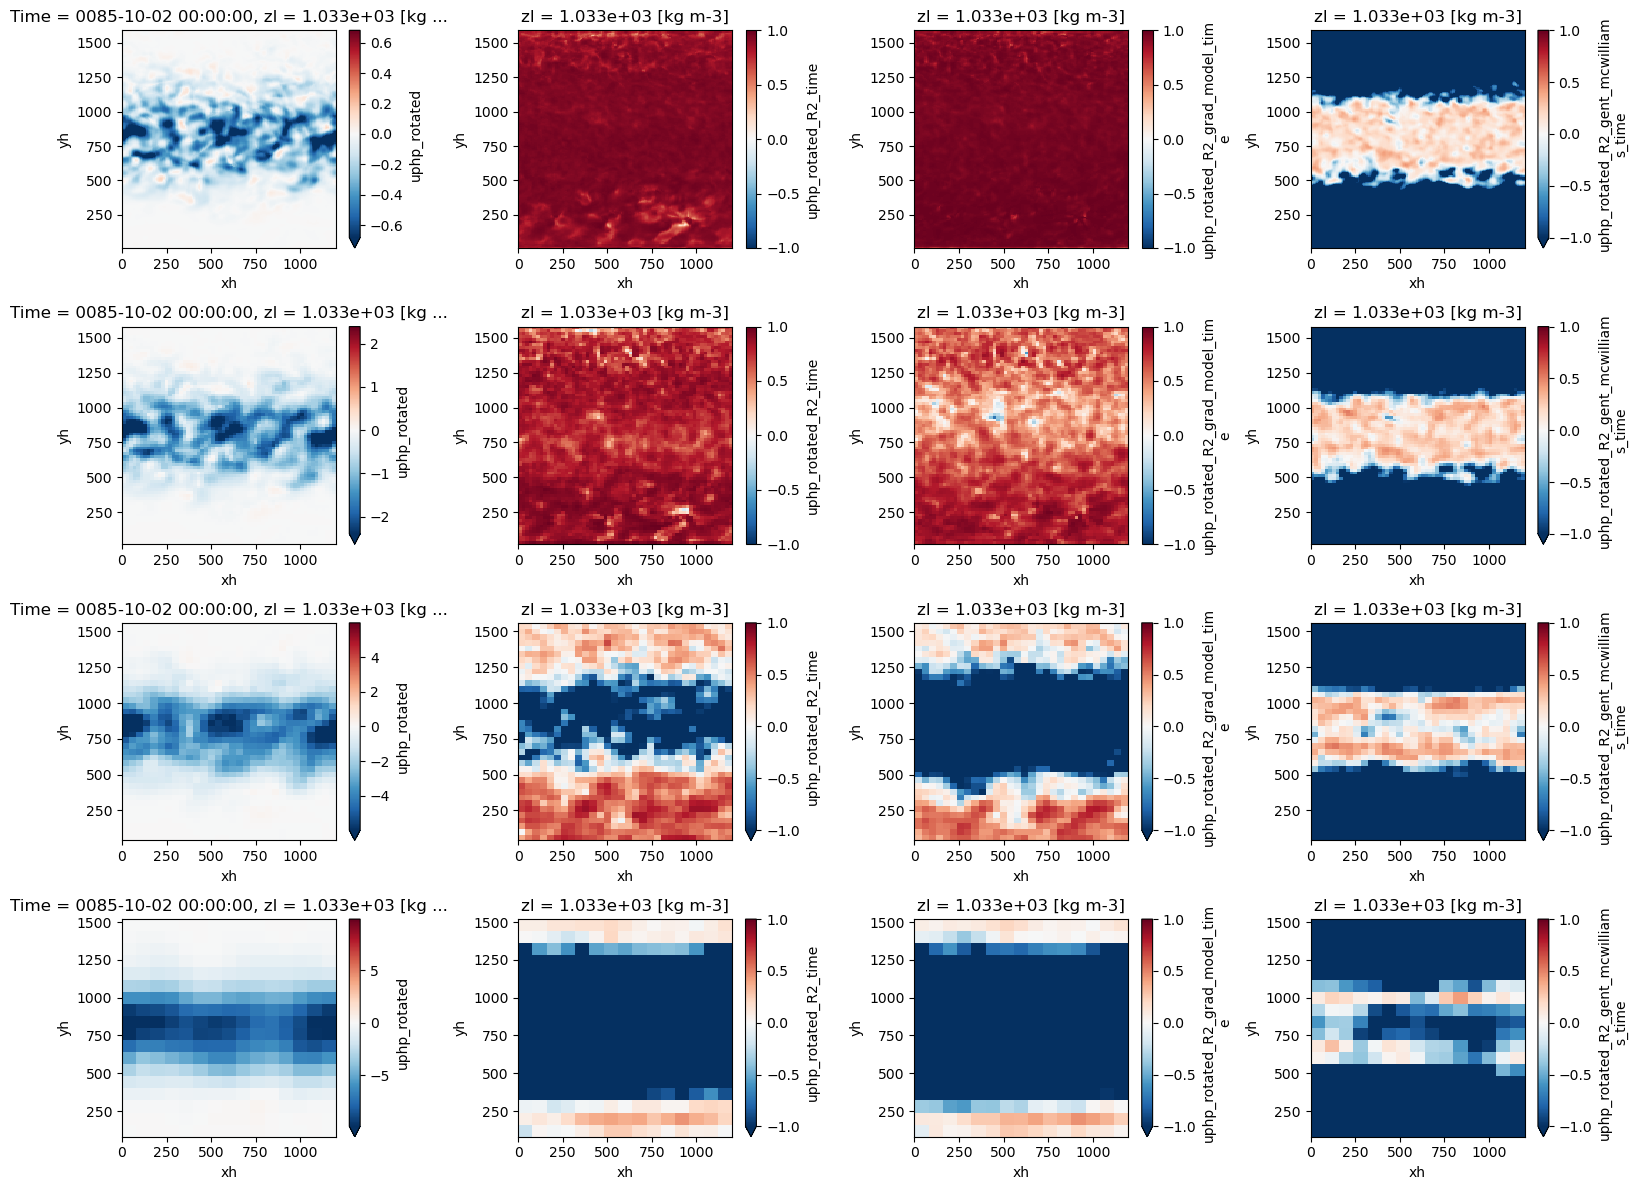

In [93]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'P2L'

vmins = [-1, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

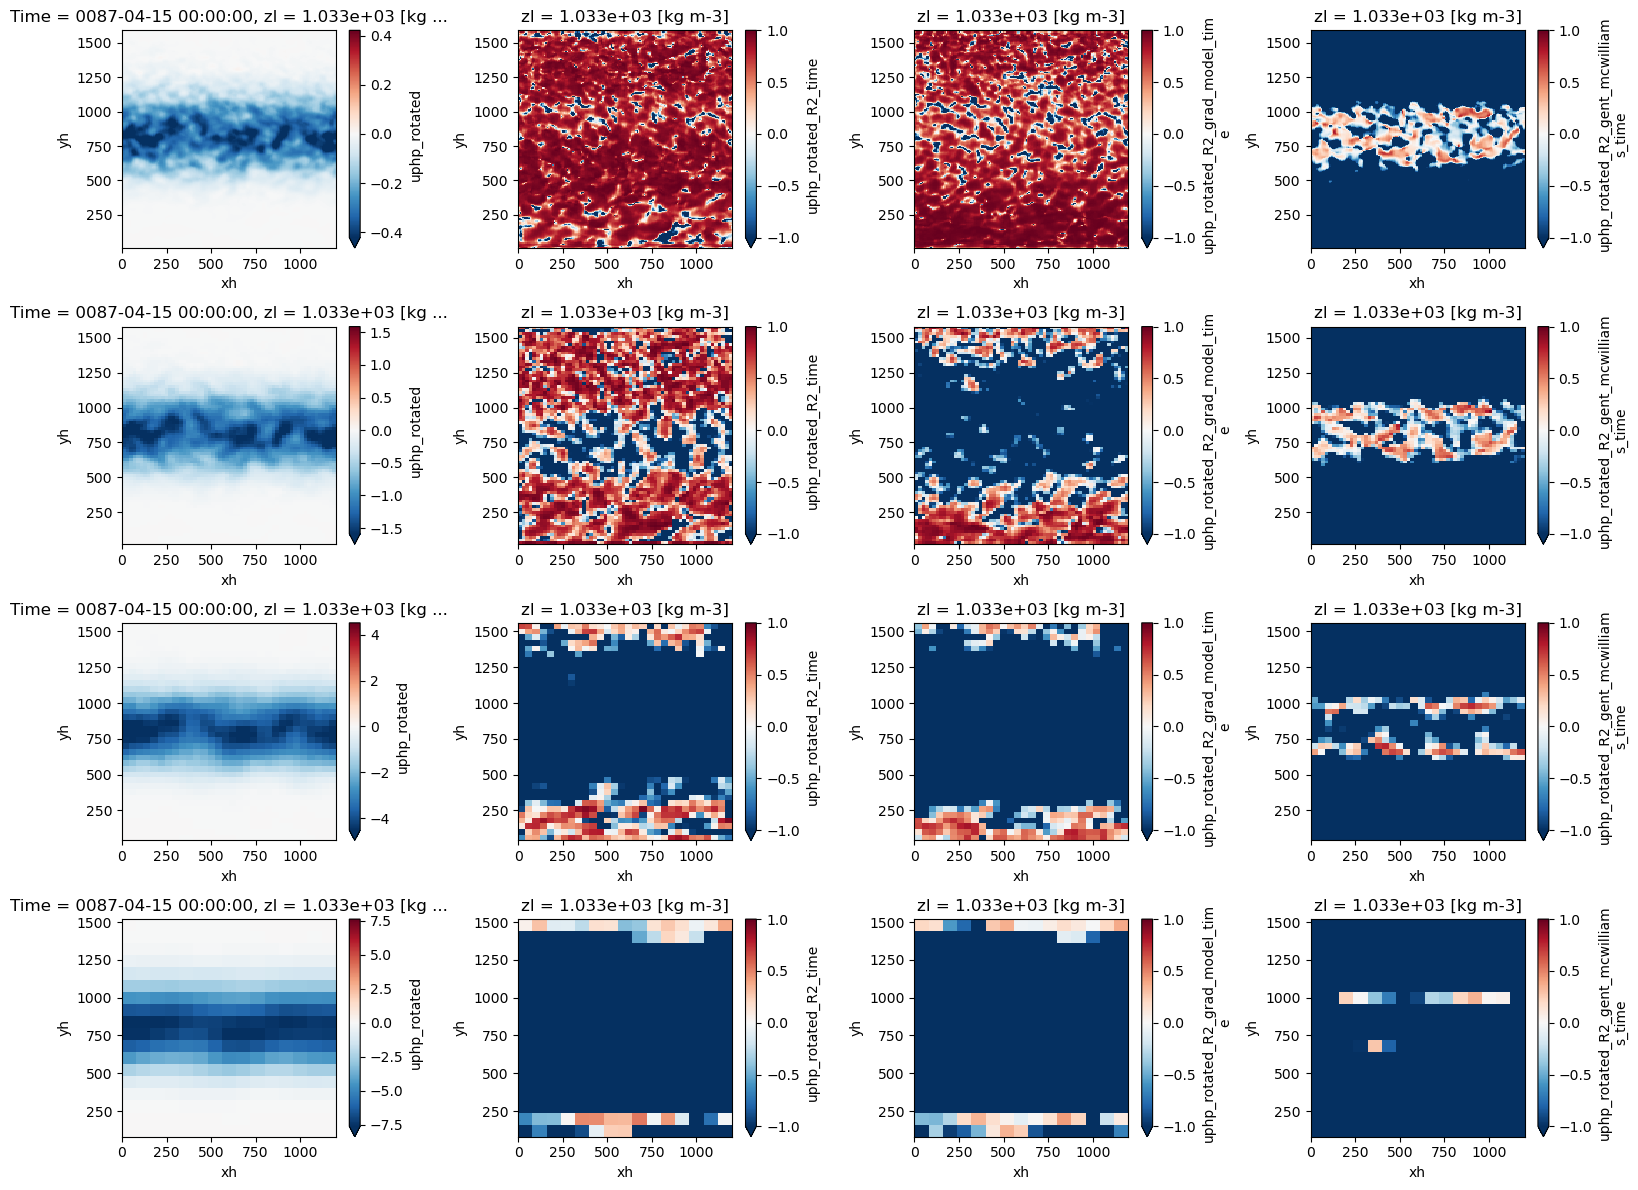

In [94]:
plt.figure(figsize=(16,12))

coarsen_scale = '128'
exp = 'P2L'

vmins = [-1, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_R2_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

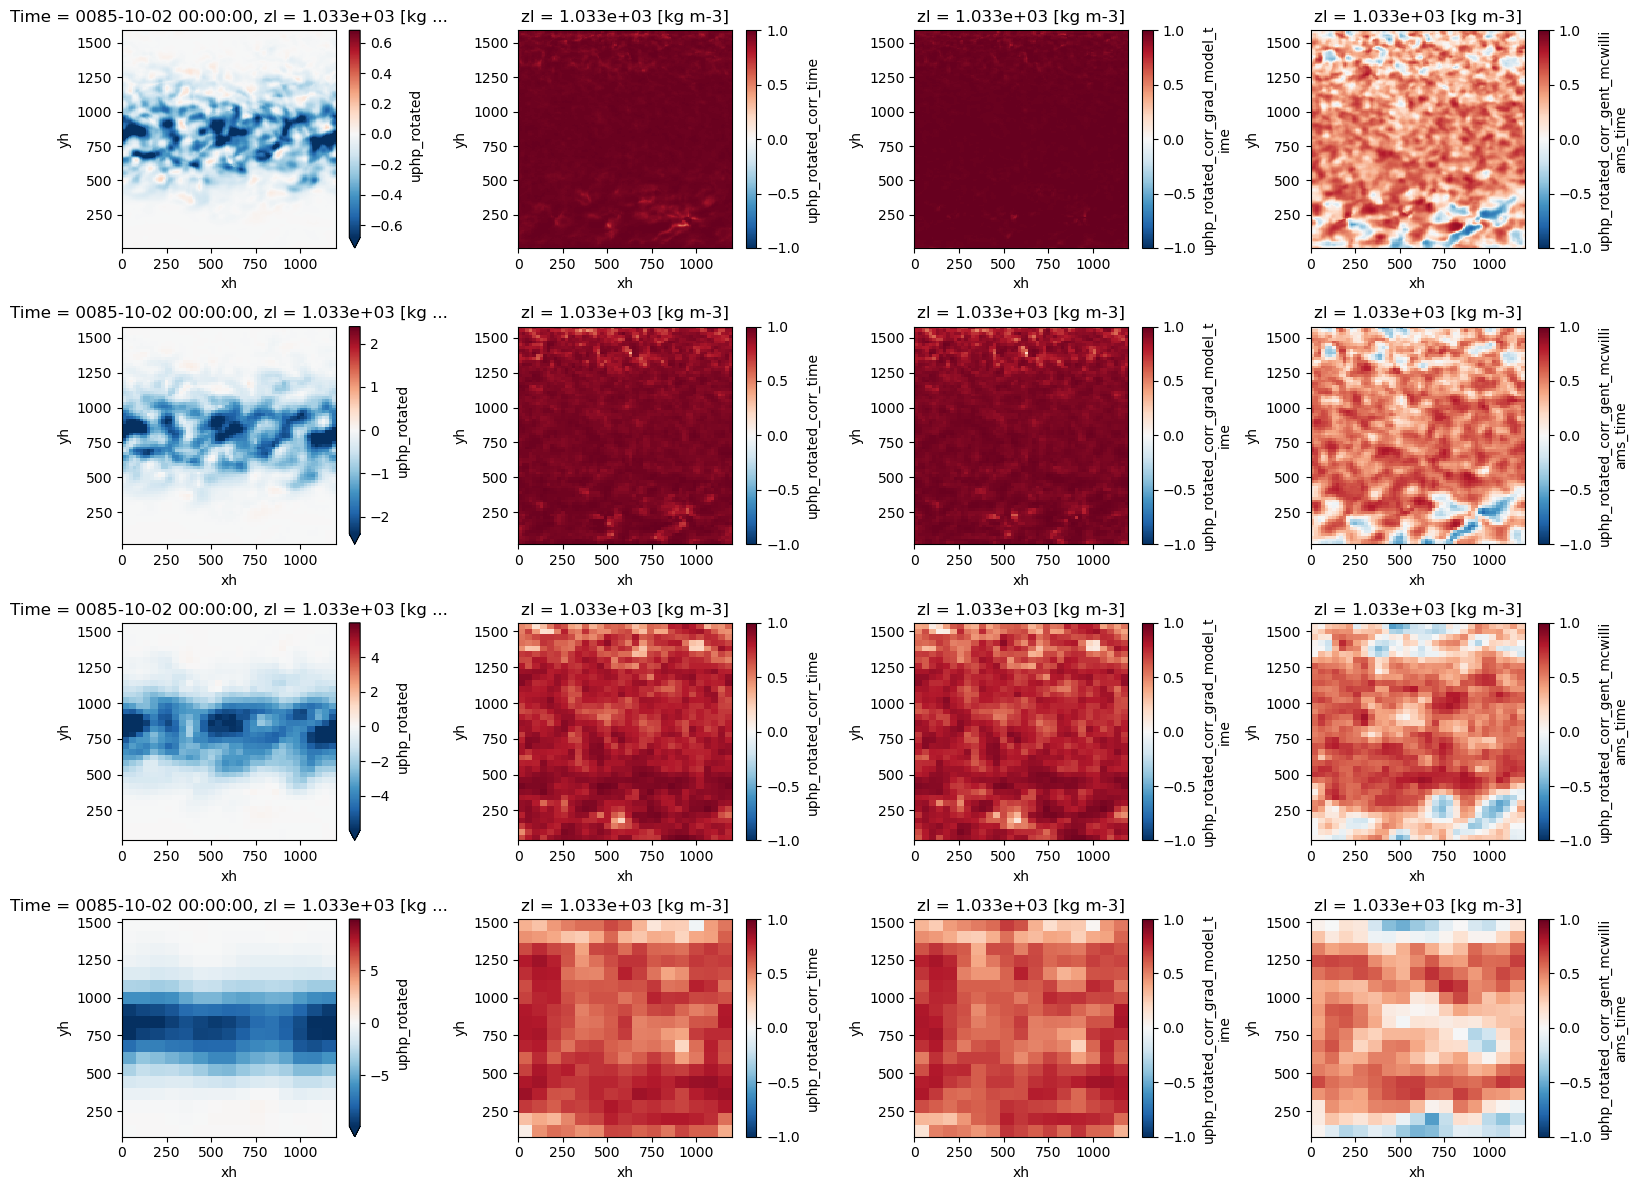

In [95]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'P2L'

vmins = [-1, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

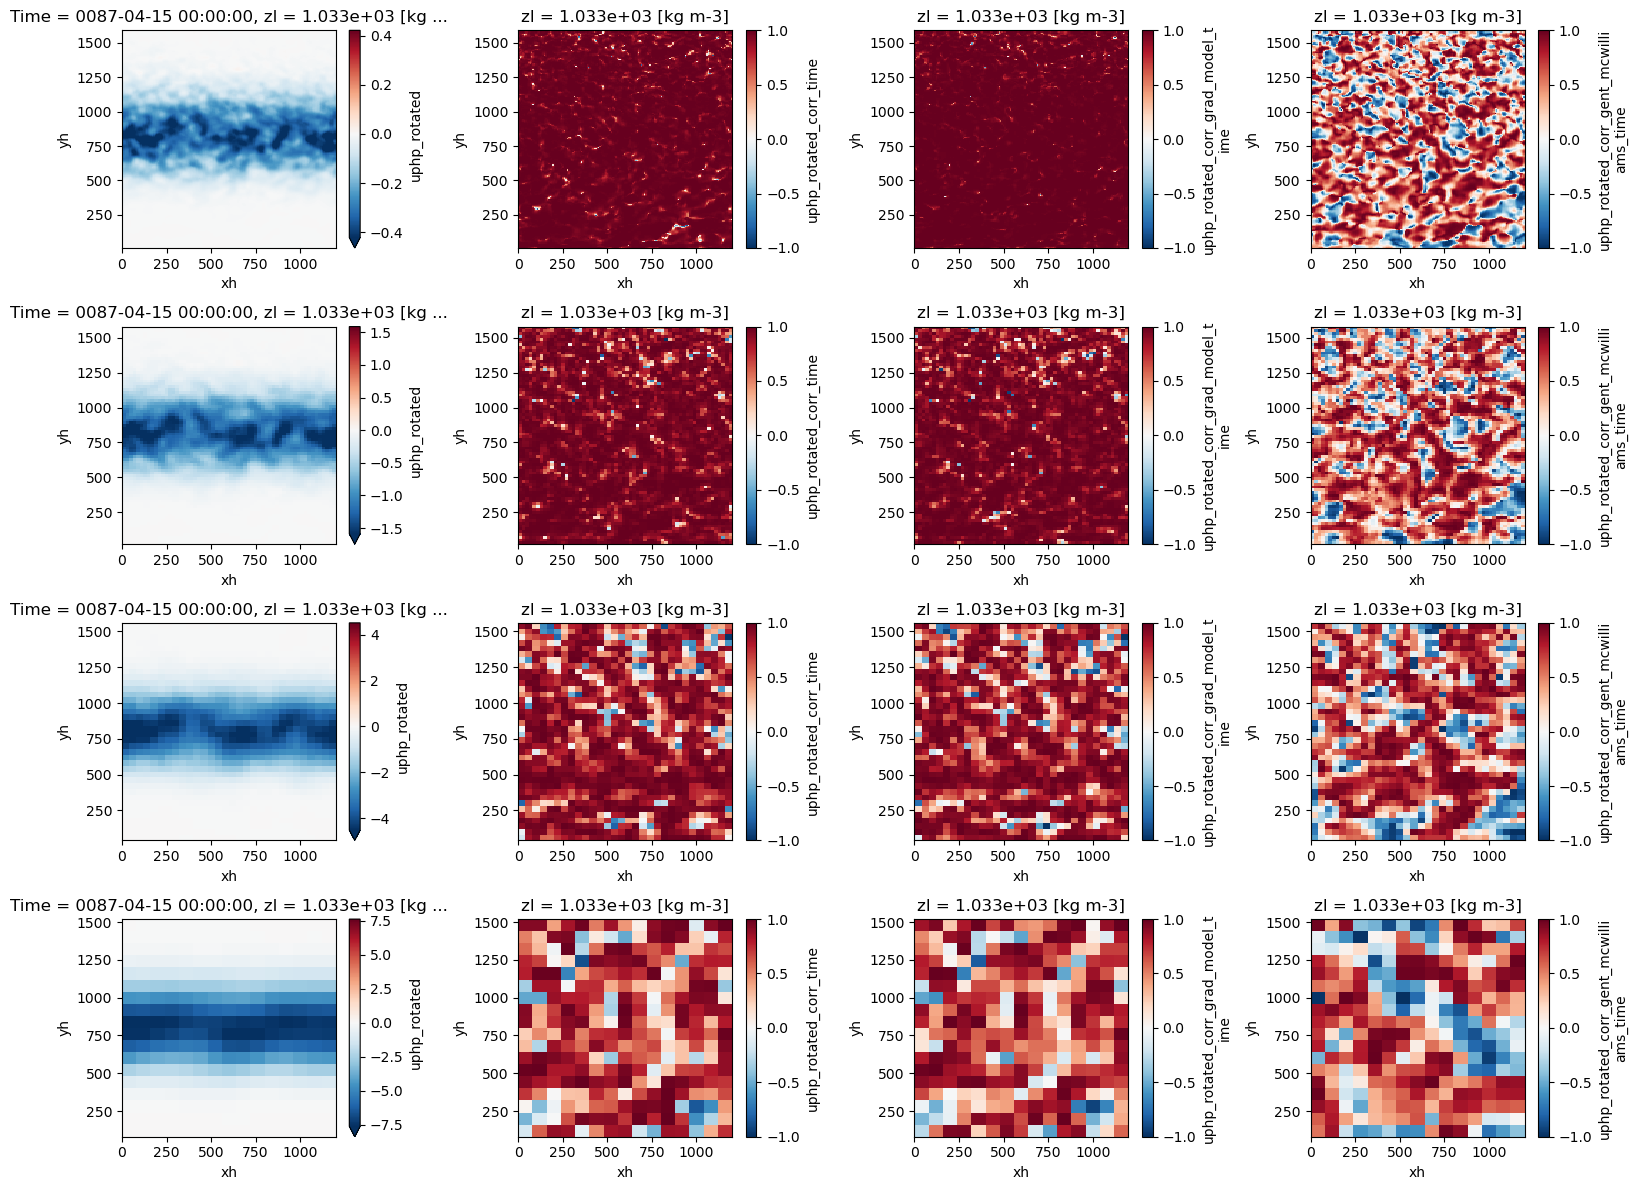

In [96]:
plt.figure(figsize=(16,12))

coarsen_scale = '128'
exp = 'P2L'

vmins = [-1, -1, -1, -1]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_time.isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_grad_model_time.isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_corr_gent_mcwilliams_time.isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

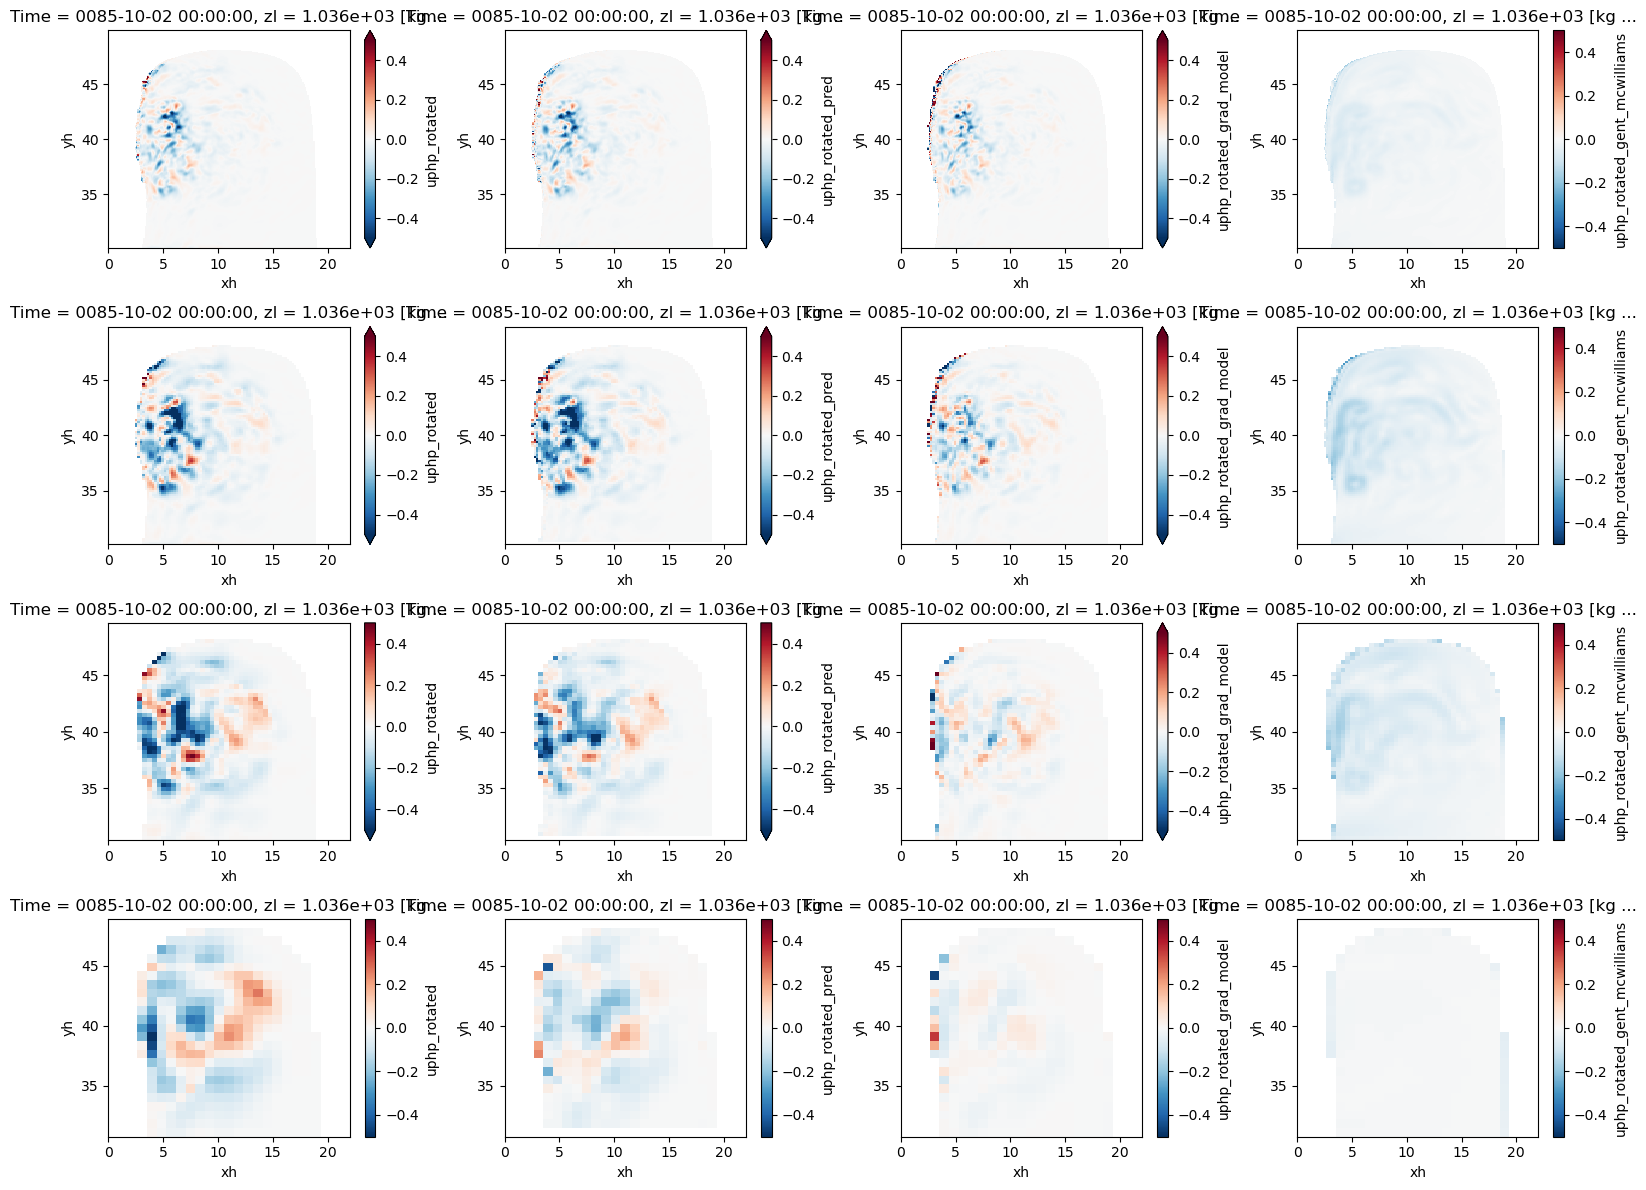

In [27]:
plt.figure(figsize=(16,12))

coarsen_scale = '16'
exp = 'DG'

vmins = [-0.5, -0.5, -0.5, -.5]
for i, filter_scale in enumerate(filter_scales):
    
    
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

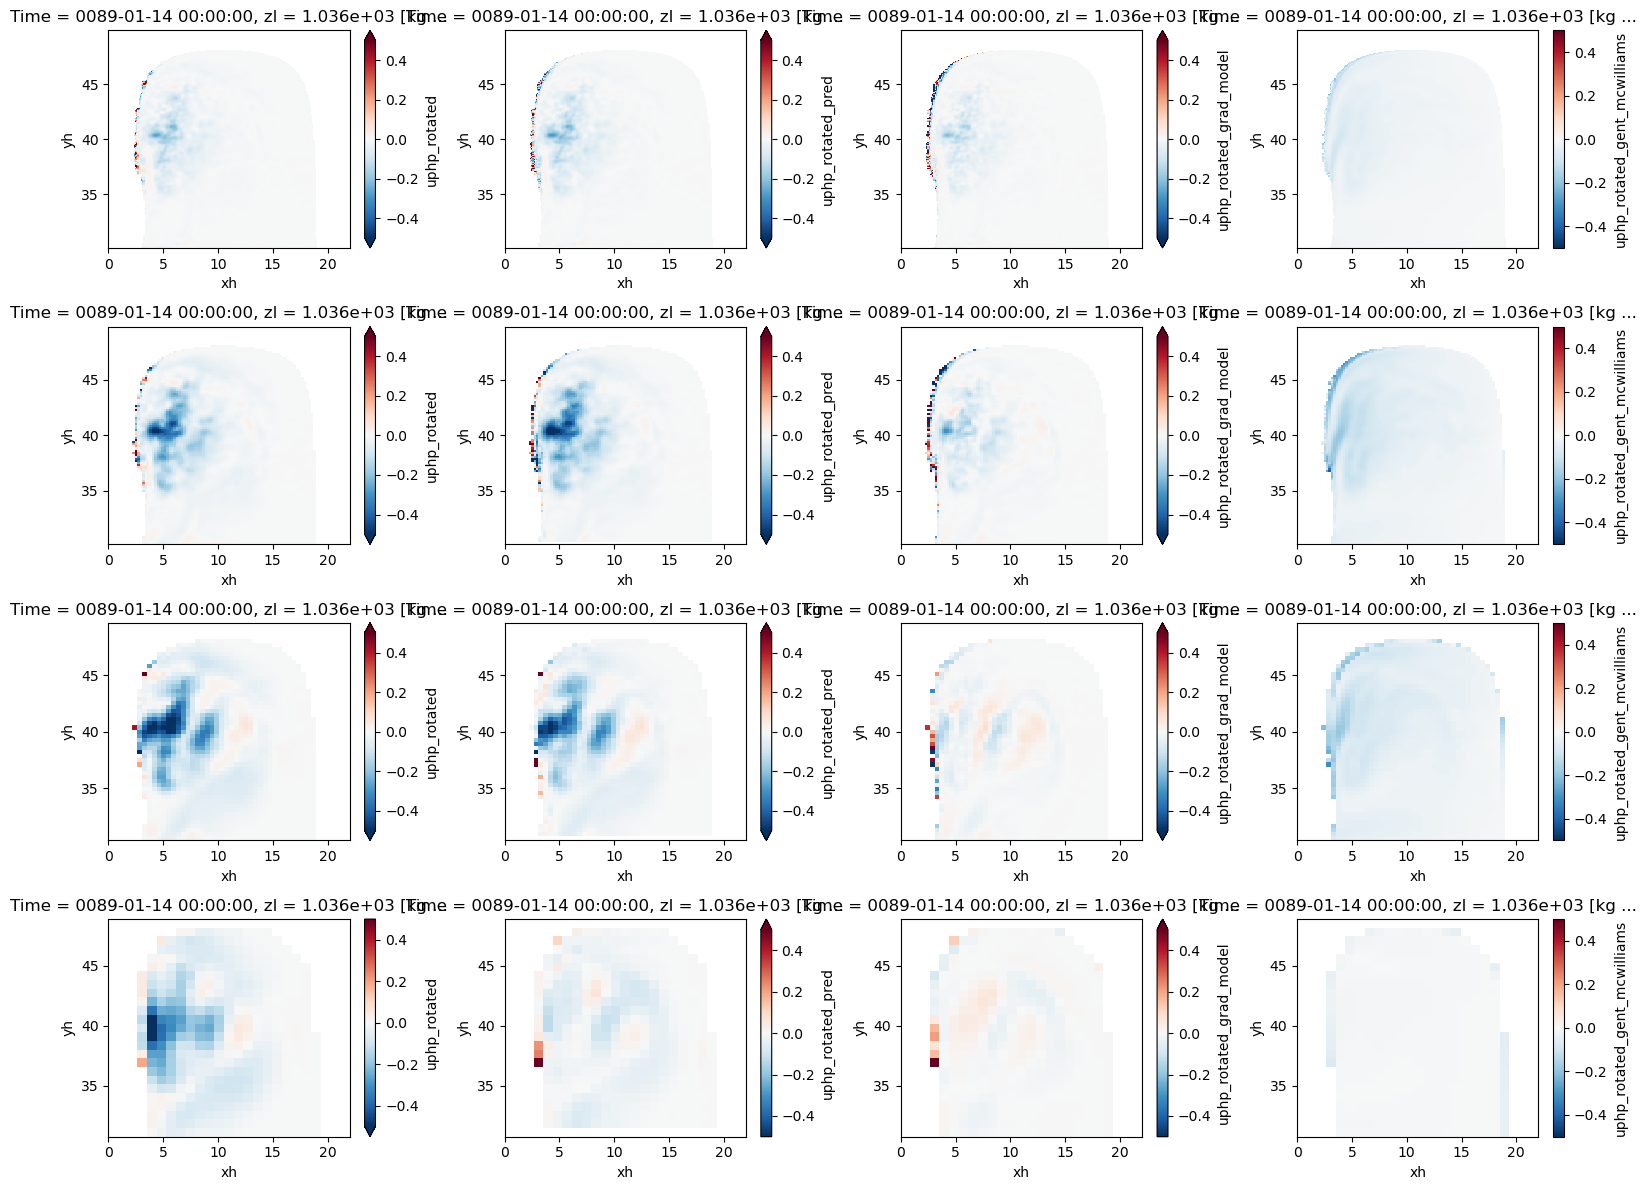

In [26]:
plt.figure(figsize=(16,12))

coarsen_scale = '256'
exp = 'DG'

vmins = [-0.5, -0.5, -0.5, -.5]
for i, filter_scale in enumerate(filter_scales):
    
    vmin = vmins[i]
    
    plt.subplot(4,4,1+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated.isel(Time=0).isel(zl=1).plot(vmin=vmin)
    
    plt.subplot(4,4,2+i*4)
    experiment_configs['3point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_pred.isel(Time=0).isel(zl=1).plot(vmin=vmin, cmap='RdBu_r')
    
    plt.subplot(4,4,3+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_grad_model.isel(Time=0).isel(zl=1).plot(vmin=vmin,  cmap='RdBu_r')
    
    plt.subplot(4,4,4+i*4)
    experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset[exp][filter_scale][coarsen_scale].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')
    
plt.tight_layout()

What is going on with the Double Gyre sim? 

In [37]:
xh_sel = slice(5, 17)
yh_sel = slice(32, 42)

# Extract box boundaries
x_min, x_max = xh_sel.start, xh_sel.stop
y_min, y_max = yh_sel.start, yh_sel.stop

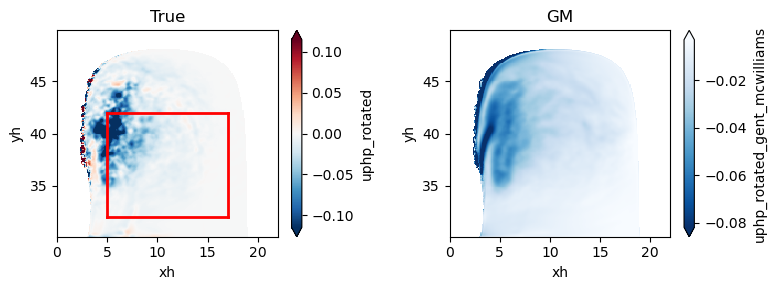

In [83]:
plt.figure(figsize=(8,3))

Lscale = '50'

plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
plt.title('True')

# Draw only the box edges using four line segments
plt.plot([x_min, x_max], [y_min, y_min], 'r-', linewidth=2)  # Bottom edge
plt.plot([x_min, x_max], [y_max, y_max], 'r-', linewidth=2)  # Top edge
plt.plot([x_min, x_min], [y_min, y_max], 'r-', linewidth=2)  # Left edge
plt.plot([x_max, x_max], [y_min, y_max], 'r-', linewidth=2)  # Right edge

plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(robust=True, cmap='Blues_r')
plt.title('GM')

plt.tight_layout()

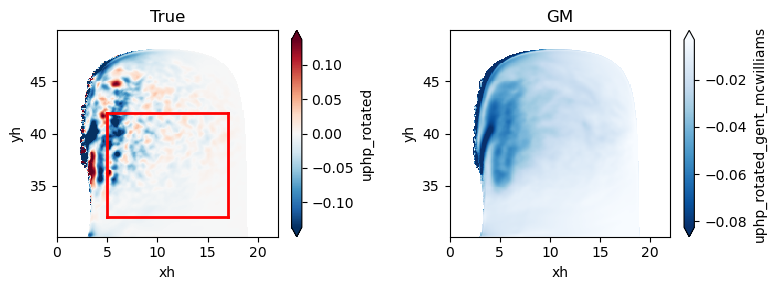

In [84]:
plt.figure(figsize=(8,3))

Lscale = '50'

plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated.isel(Time=0).isel(zl=0).plot(robust=True)
plt.title('True')

# Draw only the box edges using four line segments
plt.plot([x_min, x_max], [y_min, y_min], 'r-', linewidth=2)  # Bottom edge
plt.plot([x_min, x_max], [y_max, y_max], 'r-', linewidth=2)  # Top edge
plt.plot([x_min, x_min], [y_min, y_max], 'r-', linewidth=2)  # Left edge
plt.plot([x_max, x_max], [y_min, y_max], 'r-', linewidth=2)  # Right edge

plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=0).plot(robust=True, cmap='Blues_r')
plt.title('GM')

plt.tight_layout()

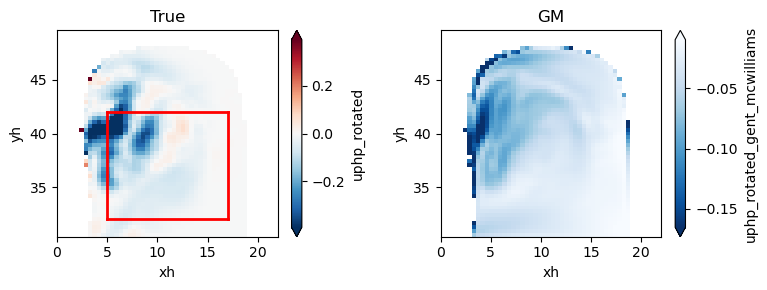

In [85]:
plt.figure(figsize=(8,3))

Lscale = '200'

plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated.isel(Time=0).isel(zl=1).plot(robust=True)
plt.title('True')

# Draw only the box edges using four line segments
plt.plot([x_min, x_max], [y_min, y_min], 'r-', linewidth=2)  # Bottom edge
plt.plot([x_min, x_max], [y_max, y_max], 'r-', linewidth=2)  # Top edge
plt.plot([x_min, x_min], [y_min, y_max], 'r-', linewidth=2)  # Left edge
plt.plot([x_max, x_max], [y_min, y_max], 'r-', linewidth=2)  # Right edge

plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=1).plot(robust=True, cmap='Blues_r')
plt.title('GM')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,3))

Lscale = '50'

plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated.isel(Time=0).isel(zl=0).plot(robust=True)
plt.title('True')

# Draw only the box edges using four line segments
plt.plot([x_min, x_max], [y_min, y_min], 'r-', linewidth=2)  # Bottom edge
plt.plot([x_min, x_max], [y_max, y_max], 'r-', linewidth=2)  # Top edge
plt.plot([x_min, x_min], [y_min, y_max], 'r-', linewidth=2)  # Left edge
plt.plot([x_max, x_max], [y_min, y_max], 'r-', linewidth=2)  # Right edge

plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=0).plot(robust=True, cmap='Blues_r')
plt.title('GM')

plt.tight_layout()

In [61]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256']

DataTree('256', parent="400")
    Dimensions:                                      (Time: 2, zl: 2, yh: 25,
                                                      xh: 25, Xn: 1, Yn: 1)
    Coordinates:
      * Time                                         (Time) object 16B 0089-01-14...
      * xh                                           (xh) float64 200B 0.44 ... 2...
      * yh                                           (yh) float64 200B 31.09 ... ...
      * zl                                           (zl) float64 16B 1.035e+03 1...
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/42)
        dudx_widened_rotated_nondim                  (Time, zl, yh, xh, Xn, Yn) float64 20kB dask.array<chunksize=(1, 2, 25, 25, 1, 1), meta=np.ndarray>
        dvdx_widened_rotated_nondim                  (Time, zl, yh, xh, Xn, Yn) float64 20kB dask.array<chunksize=(1, 2, 25, 25, 1, 1), meta=np.ndarray>
        dudy_widened_rotated_nondim                  (Time, zl, yh, xh, Xn, Yn) float64 20kB dask.array<chunksize=(1, 2, 25, 25, 1, 1), meta=np.ndarray>
        dvdy_widened_rotated_nondim                  (Time, zl, yh, xh, Xn, Yn) float64 20kB dask.array<chunksize=(1, 2, 25, 25, 1, 1), meta=np.ndarray>
        dhdx_widened_rotated_nondim                  (Time, zl, yh, xh, Xn, Yn) float64 20kB dask.array<chunksize=(1, 2, 25, 25, 1, 1), meta=np.ndarray>
        dhdy_widened_rotated_nondim                  (Time, zl, yh, xh, Xn, Yn) float64 20kB dask.array<chunksize=(1, 2, 25, 25, 1, 1), meta=np.ndarray>
        ...                                           ...
        vphp_rotated_R2_grad_model_layerwise         (zl) float64 16B 0.3209 0.01034
        vphp_rotated_corr_grad_model_layerwise       (zl) float64 16B 0.6611 0.5254
        vphp_rotated_mse_grad_model_layerwise        (zl) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
        vphp_rotated_R2_gent_mcwilliams_layerwise    (zl) float64 16B -0.02009 -0...
        vphp_rotated_corr_gent_mcwilliams_layerwise  (zl) float64 16B -0.004034 -...
        vphp_rotated_mse_gent_mcwilliams_layerwise   (zl) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     400
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 400 km resolution

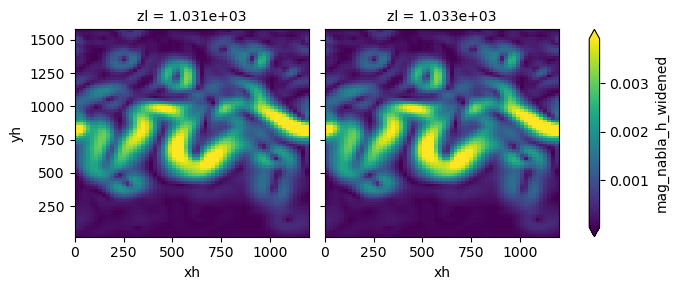

In [70]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['100'].mag_nabla_h_widened.isel(Time=0).plot(col='zl', robust=True)

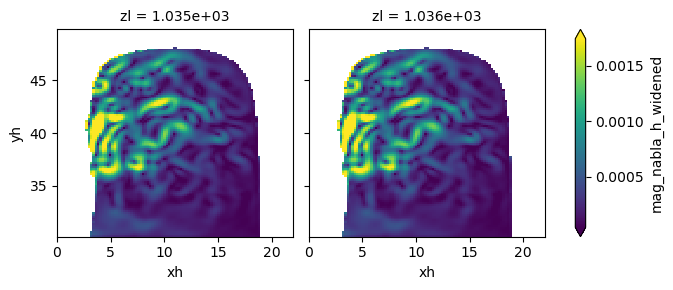

In [67]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].mag_nabla_h_widened.isel(Time=0).plot(col='zl', robust=True)

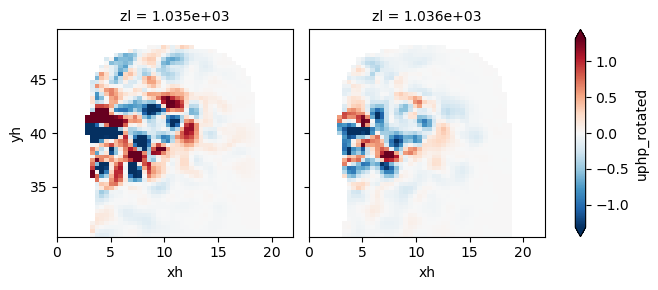

In [74]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['200'].uphp_rotated.isel(Time=0).plot(col='zl', robust=True)

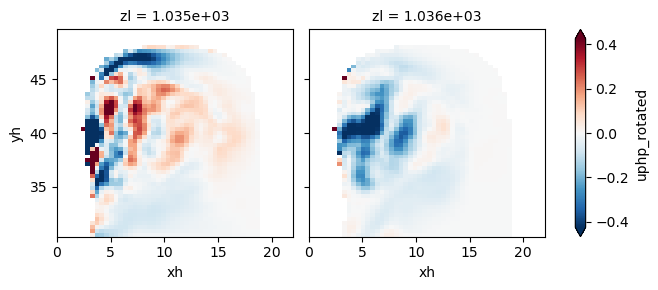

In [73]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG']['200']['256'].uphp_rotated.isel(Time=0).plot(col='zl', robust=True)

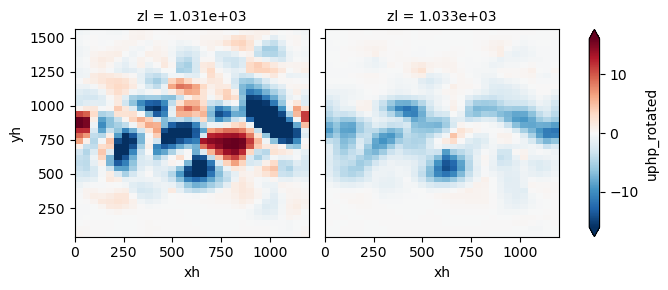

In [75]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['200'].uphp_rotated.isel(Time=0).plot(col='zl', robust=True)

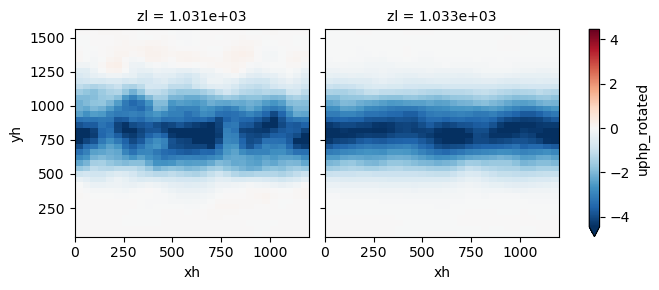

In [76]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L']['200']['256'].uphp_rotated.isel(Time=0).plot(col='zl', robust=True)

In [ ]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L'][Lscale].uphp_rotated.isel(Time=0).plot(col='zl', robust=True)

In [60]:
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['DG'][Lscale]['256'].gradh.isel(Xn=0, Yn=0, Time=0).plot(col='zl')


AttributeError: 'DataTree' object has no attribute 'gradh'

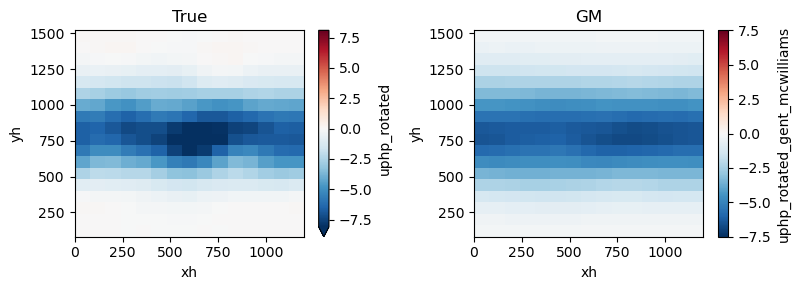

In [53]:
plt.figure(figsize=(8,3))

Lscale = '400'
zl = 0

plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L'][Lscale]['256'].uphp_rotated.isel(Time=0).isel(zl=zl).plot(robust=True)
plt.title('True')


plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L'][Lscale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=zl).plot(vmin=-7.5, vmax=7.5, cmap='RdBu_r')
plt.title('GM')

plt.tight_layout()

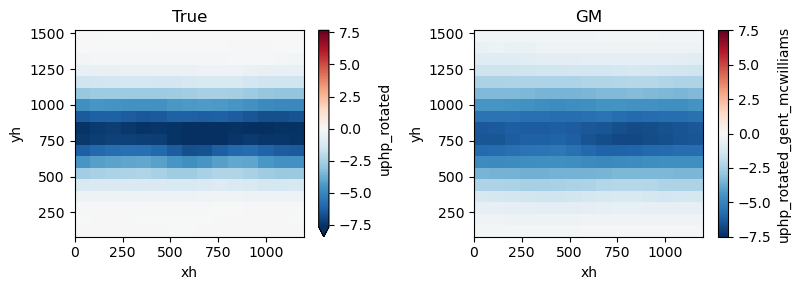

In [54]:
plt.figure(figsize=(8,3))

Lscale = '400'
zl = 1

plt.subplot(121)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L'][Lscale]['256'].uphp_rotated.isel(Time=0).isel(zl=zl).plot(robust=True)
plt.title('True')


plt.subplot(122)
experiment_configs['1point']['eval_sys'].eval_datatree.ml_dataset['P2L'][Lscale]['256'].uphp_rotated_gent_mcwilliams.isel(Time=0).isel(zl=zl).plot(vmin=-7.5, vmax=7.5, cmap='RdBu_r')
plt.title('GM')

plt.tight_layout()

In [ ]:
import time

for i in range(20 * 60):  # 20 minutes * 60 seconds
    if i % 60 == 0:  # Print every minute
        print(f"Keeping kernel alive... {i//60} minutes elapsed")
    time.sleep(1)  # Wait 1 second